<a href="https://colab.research.google.com/github/nobu-n2002/CFD2023_image_processing/blob/main/ibm_image_processing_ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Preprocessing for Immersed Boundary Method

In this notebook, general image processing techniques are employed on 2D images and subsequently applied to a numerical simulation program utilizing A new unified governing equation of flow incorporating immersed solid boundaries.

## Basic equation

Law of conservation of mass:
\begin{align}
\frac{\partial \rho \varepsilon}{\partial t}+\boldsymbol{\bigtriangledown} \cdot \rho \varepsilon \boldsymbol{u} = 0
\end{align}

Law of conservation of momentum:
\begin{align}
\frac{\partial \rho \varepsilon \boldsymbol{u}}{\partial t}+\bigtriangledown \cdot \rho \varepsilon \boldsymbol{u} \boldsymbol{u}
= -\varepsilon\bigtriangledown p + \bigtriangledown\cdot \varepsilon \boldsymbol{T} + \boldsymbol{f}\\
\boldsymbol{T} = \mu(\bigtriangledown\boldsymbol{u}+\bigtriangledown\boldsymbol{u}^t)+\lambda (\bigtriangledown\cdot\boldsymbol{u})\boldsymbol{I}
\end{align}

Defenition of porosity distribution:

\begin{align}
\displaystyle \varepsilon = \frac{1}{2} \tanh(x) + \frac{1}{2},  x = \frac{\xi}{\Delta}
\end{align}

where $\xi$ is a signed distance function.

# 1. Preparation before execution

## Connect to Google Drive
If you wish to execute while connecting to Google Drive, enable `connect: [check]`. Upon execution, access to Google Drive will be requested. Once approved, you will have access to your own drive.

In [14]:
# @title Connect to Google Drive { run: "auto", vertical-output: true, display-mode: "form" }

from google.colab import drive

# Parameters
connect = False  # @param {type:"boolean"}

# Mount Google Drive if selected
if connect:
    drive.mount('/content/drive')
    print('Google Drive connected!')
else:
    print('Google Drive not connected.')


Google Drive not connected.


## Importing non-standard modules
Install non-standard modules on Google Colab. This won't affect your local environment. The execution may take around 1 minute.

In [15]:
#@title Importing non-standard modules into Colabo

%%capture

# update apt-get and upgrade pip (for installing modules)
!apt-get update
!apt-get upgrade pip

# pyheif : use to convert heic files to png
%pip install pyheif

# For using skfmm which is a tool to compute SDF (signed distance field)
%pip install scikit-fmm

# pyvista : use to visualise vtk files
!apt-get install xvfb libgl1-mesa-glx
%pip install pyvista

# 2. Image processing

The image file is converted to grayscale, and a blur is applied as a variant distance function to generate a porosity distribution.


## 2-1. File Input
Enable `use_upload: [check]` to choose a local file. Alternatively, manually input the file path for the uploaded file in `./content/` into `file_path:`.

sample (10) successfully read
Original resolution: (756, 756)
Save the figure in ./tmp/original.png


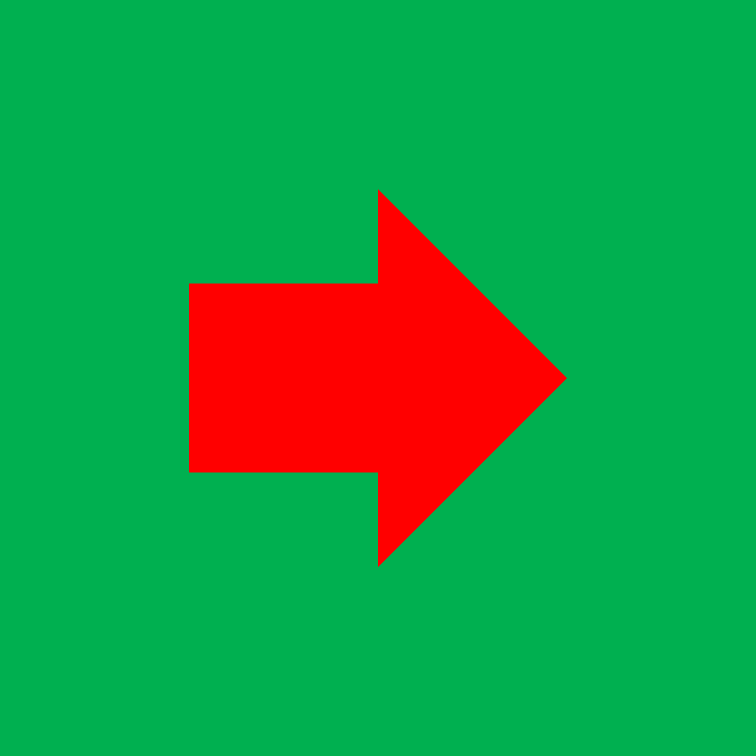

In [19]:
# @title File Input { vertical-output: true, display-mode: "form" }

import os
import sys
from IPython.display import display, Image
import cv2
import pyheif
from google.colab import files

# Function to convert HEIC to PNG
def heif_to_image(path):
    heif_file = pyheif.read(path)
    img = Image.frombytes(heif_file.mode,
                          heif_file.size,
                          heif_file.data,
                          "raw",
                          heif_file.mode,
                          heif_file.stride,)
    print('HEIC successfully converted into PNG')
    return img

# Parameters
use_upload = False  # @param {type:"boolean"}
file_path = "/content/sample (10).png"  # @param {type:"string"}
upload_button = None

# Check if 'tmp' folder exists, create if not
if not os.path.exists('tmp'):
    print('Creating a tmp folder')
    os.mkdir('tmp')

# Upload files if selected
if use_upload:
    upload_button = files.upload()

# Get the file path
if use_upload and len(upload_button) > 0:
    file_path_input = list(upload_button.keys())[0]
    file_path = file_path_input
else:
    file_path_input = file_path

# Check if the file exists
if os.path.exists(file_path_input):
    file_name, file_extension = os.path.splitext(os.path.basename(file_path_input))

    # Check if the file is in HEIC format and convert to PNG if needed
    if file_extension.lower() == '.heic':
        img = heif_to_image(file_path_input)
        img.save(f"./tmp/{file_name}.png", "PNG")
        file_path = f"./tmp/{file_name}.png"

    print(f'{file_name} successfully read')
    original_image = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
    height, width = original_image.shape[0:2]

    file_path_original = f"./tmp/original.png"
    cv2.imwrite(file_path_original, original_image)

    print('Original resolution:', original_image.shape[0:2])
    print('\033[32m' + f'Save the figure in {file_path_original}' + '\033[0m')
    display(Image(file_path, width=500))
else:
    sys.exit('No file input')


## 2-2. Cropping and Adding Margins

Add padding to the loaded file. The original resolution of the file can be found in the code block above [File Input] with `Original resolution: (WIDTH, HEIGHT)`, allowing you to verify it. Add a margin of `MARGIN` pixels to match that resolution. Choose `surroundings` for padding around the image, or `x_direction` for padding only in the horizontal direction. If the image is not a square, check ☑ 'square' to reshape it into a square.


Original resolution: (756, 756)
Processed resolution: (1756, 1756)
Save the figure in /content/tmp/cropped.png


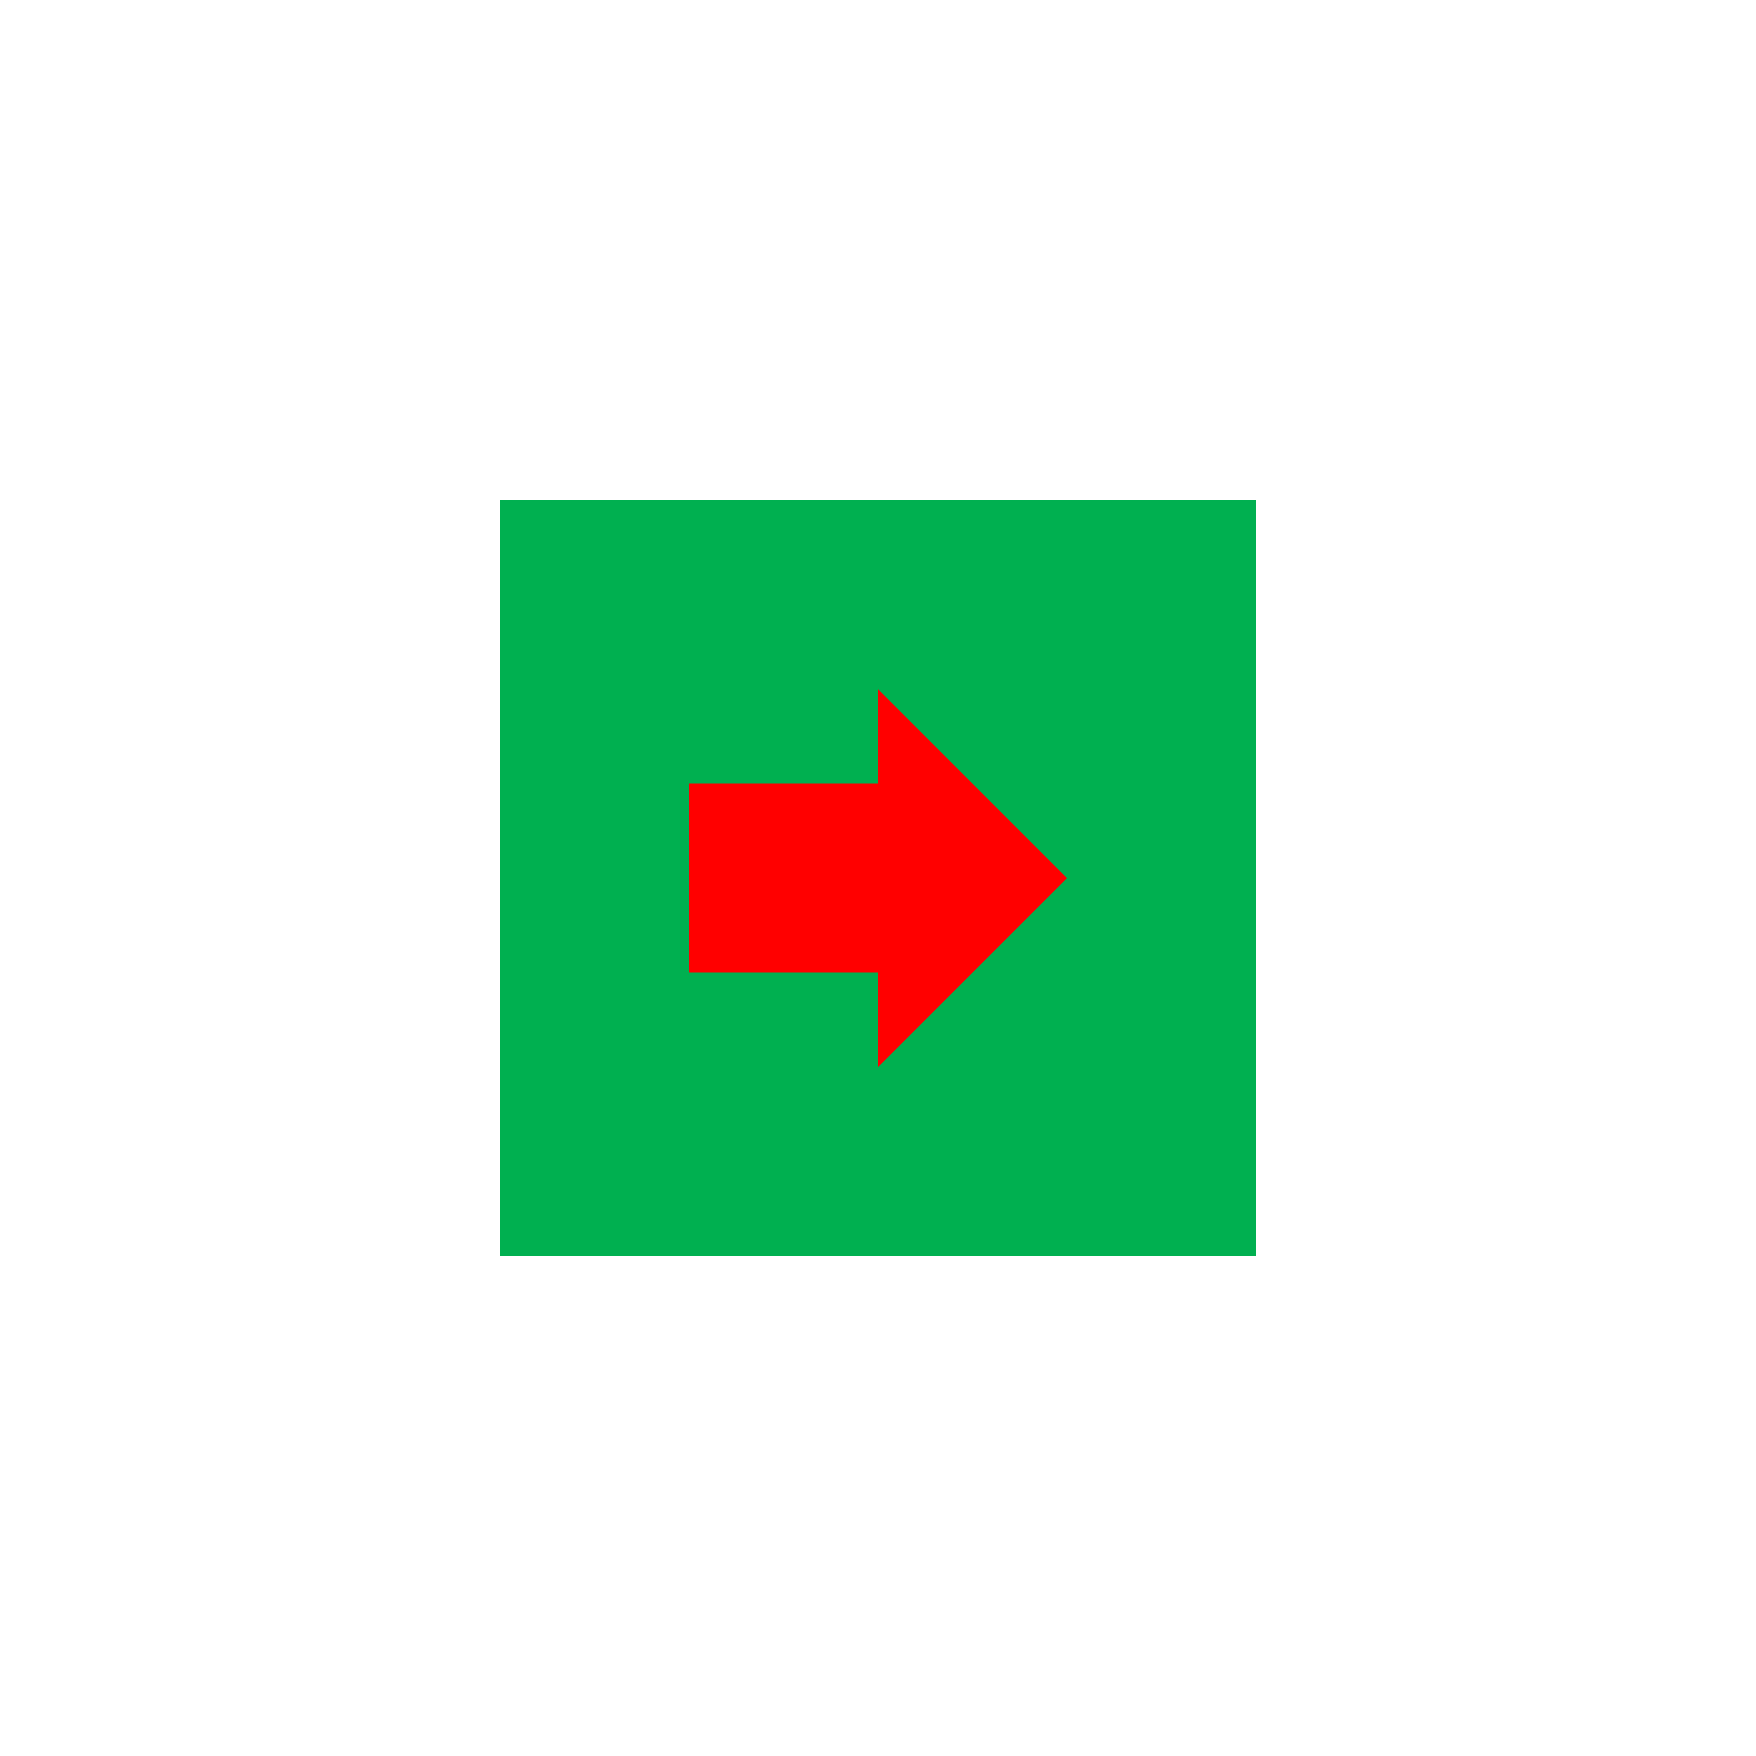

In [20]:
# @title Cropping and Adding Margins { run: "auto", vertical-output: true, display-mode: "form" }
# { run: "auto", vertical-output: true, display-mode: "form" }

# Import modules
import os
import cv2
from IPython.display import display, Image

# Create a tmp folder if it doesn't exist
TMP_FOLDER = 'tmp'
if not os.path.exists(TMP_FOLDER):
    print('Create a temp folder')
    os.mkdir(TMP_FOLDER)

# Parameters
MARGIN = 500 # @param {type:"slider", min:0, max:1000, step:10}

# Current working directory
CWD = os.getcwd()

file_path_original = f"./tmp/original.png"

# read an image resized
src = cv2.imread(file_path_original, cv2.IMREAD_UNCHANGED)
h_ori, w_ori = src.shape[0:2]
print('Original resolution:', src.shape[0:2])

# Set margin parameters
margin_type = "surroundings"  # @param ["x_direction", "surroundings"]
square = True # @param {type:"boolean"}
x, y = 0, 0
margin_factor_x, margin_factor_y = 0, 0

# Calculate margin for square
if square:
    tmp = h_ori - w_ori
    if tmp <= 0:
        x = int(abs(tmp) / 2)
    else:
        y = int(abs(tmp) / 2)

# Set margin factors based on type
if margin_type == "surroundings":
    margin_factor_x, margin_factor_y = 1, 1
elif margin_type == "x_direction":
    margin_factor_x, margin_factor_y = 0, 1

# Add margin to the image
img = cv2.copyMakeBorder(src, MARGIN * margin_factor_x + x, MARGIN * margin_factor_x + x,
                         MARGIN * margin_factor_y + y, MARGIN * margin_factor_y + y,
                         cv2.BORDER_CONSTANT, value=[255, 255, 255])

# Save the processed image
file_name_cropped = f"{CWD}/tmp/cropped.png"
cv2.imwrite(file_name_cropped, img)

# Display the processed image
print('Processed resolution:', img.shape[0:2])
print('\033[32m' + f'Save the figure in {file_name_cropped}' + '\033[0m')
display(Image(file_name_cropped, width=500))


##2-3. Grayscale

Grayscaling can be easily achieved by loading the previously resized image using OpenCV's `IMREAD_GRAYSCALE` function. Here, we explain the process that takes place within the image during the grayscaling process.

Each pixel in the image has a specific RGB (Red, Green, Blue) value, where each color has 256 steps ranging from 0 to 255 (i.e., $2^8$ or $16^2$). By performing the following operations on these RGB values, a grayscale image can be generated. This method follows the "Luminosity Method (ITU-R BT.601)."

$$ \rm{Gray} = Red \times 0.229 + Green \times 0.587 + Blue \times 0.114 $$

The following code block (the greyscale tester) conducts a test to convert an original BGR color (specified by user input) to grayscale by applying custom weights to each channel (B, G, R). Users can set these custom weights through sliders. The resulting grayscale intensity is calculated based on the specified weights, and the original and grayscale images are displayed side by side for visual comparison.

Original RGB: (0, 255, 0)       Gray: (254, 254, 254)


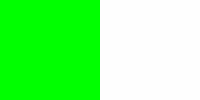

In [30]:
# @title Grayscale Tester  { run: "auto", vertical-output: true, form-width: "600px" }
import cv2
import numpy as np
from IPython.display import Image

# Define custom weights for RGB to grayscale conversion
def custom_rgb_to_grayscale(image, weights=[0.229, 0.587, 0.114]):
    """
    Convert a 3-channel RGB image to grayscale using custom weights.

    Parameters:
    - image (numpy.ndarray): Input RGB image.
    - weights (list): Custom weights for each RGB channel. Default is [0.229, 0.587, 0.114].

    Returns:
    - numpy.ndarray: Grayscale image.
    """
    # Ensure the image has three color channels (RGB)
    if len(image.shape) != 3 or image.shape[2] != 3:
        raise ValueError("Input image must be a 3-channel RGB image.")

    # Apply custom weights for RGB to grayscale conversion
    gray_image = np.dot(image[..., :3], weights)

    return gray_image

# @markdown ## Original color
# Parameters for original color
R = 0    # @param {type:"slider", min:0, max:255, step:1}
G = 255    # @param {type:"slider", min:0, max:255, step:1}
B = 0    # @param {type:"slider", min:0, max:255, step:1}

# @markdown $$ \rm{Gray} = Red \times w_1/w + Green\times w_2/w +Blue\times w_3/w $$
# @markdown $$ \rm{w} = w_1 + w_2 + w_3$$

# Custom weights for RGB to grayscale conversion
delta = 1e-6
w1 = 0    # @param {type:"slider", min:0, max:1, step:0.01}
w2 = 1    # @param {type:"slider", min:0, max:1, step:0.01}
w3 = 0    # @param {type:"slider", min:0, max:1, step:0.01}
w = w1 + w2 + w3 + delta

# BGR
custom_weights = [w3 / w, w2 / w, w1 / w]

Gray = int(R * w1 / w + G * w2 / w + B * w3 / w)
print(f'Original RGB: ({R}, {G}, {B})       Gray: ({Gray}, {Gray}, {Gray})')

# Generate 100×100(×[B, G, R]) image
omap = np.zeros((100, 100, 3), np.uint8)
omap[:, :, 0] = B
omap[:, :, 1] = G
omap[:, :, 2] = R

# Generate grayscale image
pmap = np.zeros((100, 100, 3), np.uint8)
pmap_tmp = custom_rgb_to_grayscale(omap, custom_weights)
pmap[:, :, 0] = Gray
pmap[:, :, 1] = Gray
pmap[:, :, 2] = Gray

# Concatenate the two images
dispmap = np.concatenate([omap, pmap], 1)

# Save the PNG file for display
cv2.imwrite('img.png', dispmap)
display(Image('img.png', width=600))

# Remove the PNG file
%rm img.png

###2-3-1. Threshold

When generating a grayscale image, set all values greater than the threshold to 255 (white). Adjust the grayscale weighting and threshold value to effectively lighten the background by enhancing its white tones.


Custom weights: [0.0, 1.0, 0.0]
Original color image


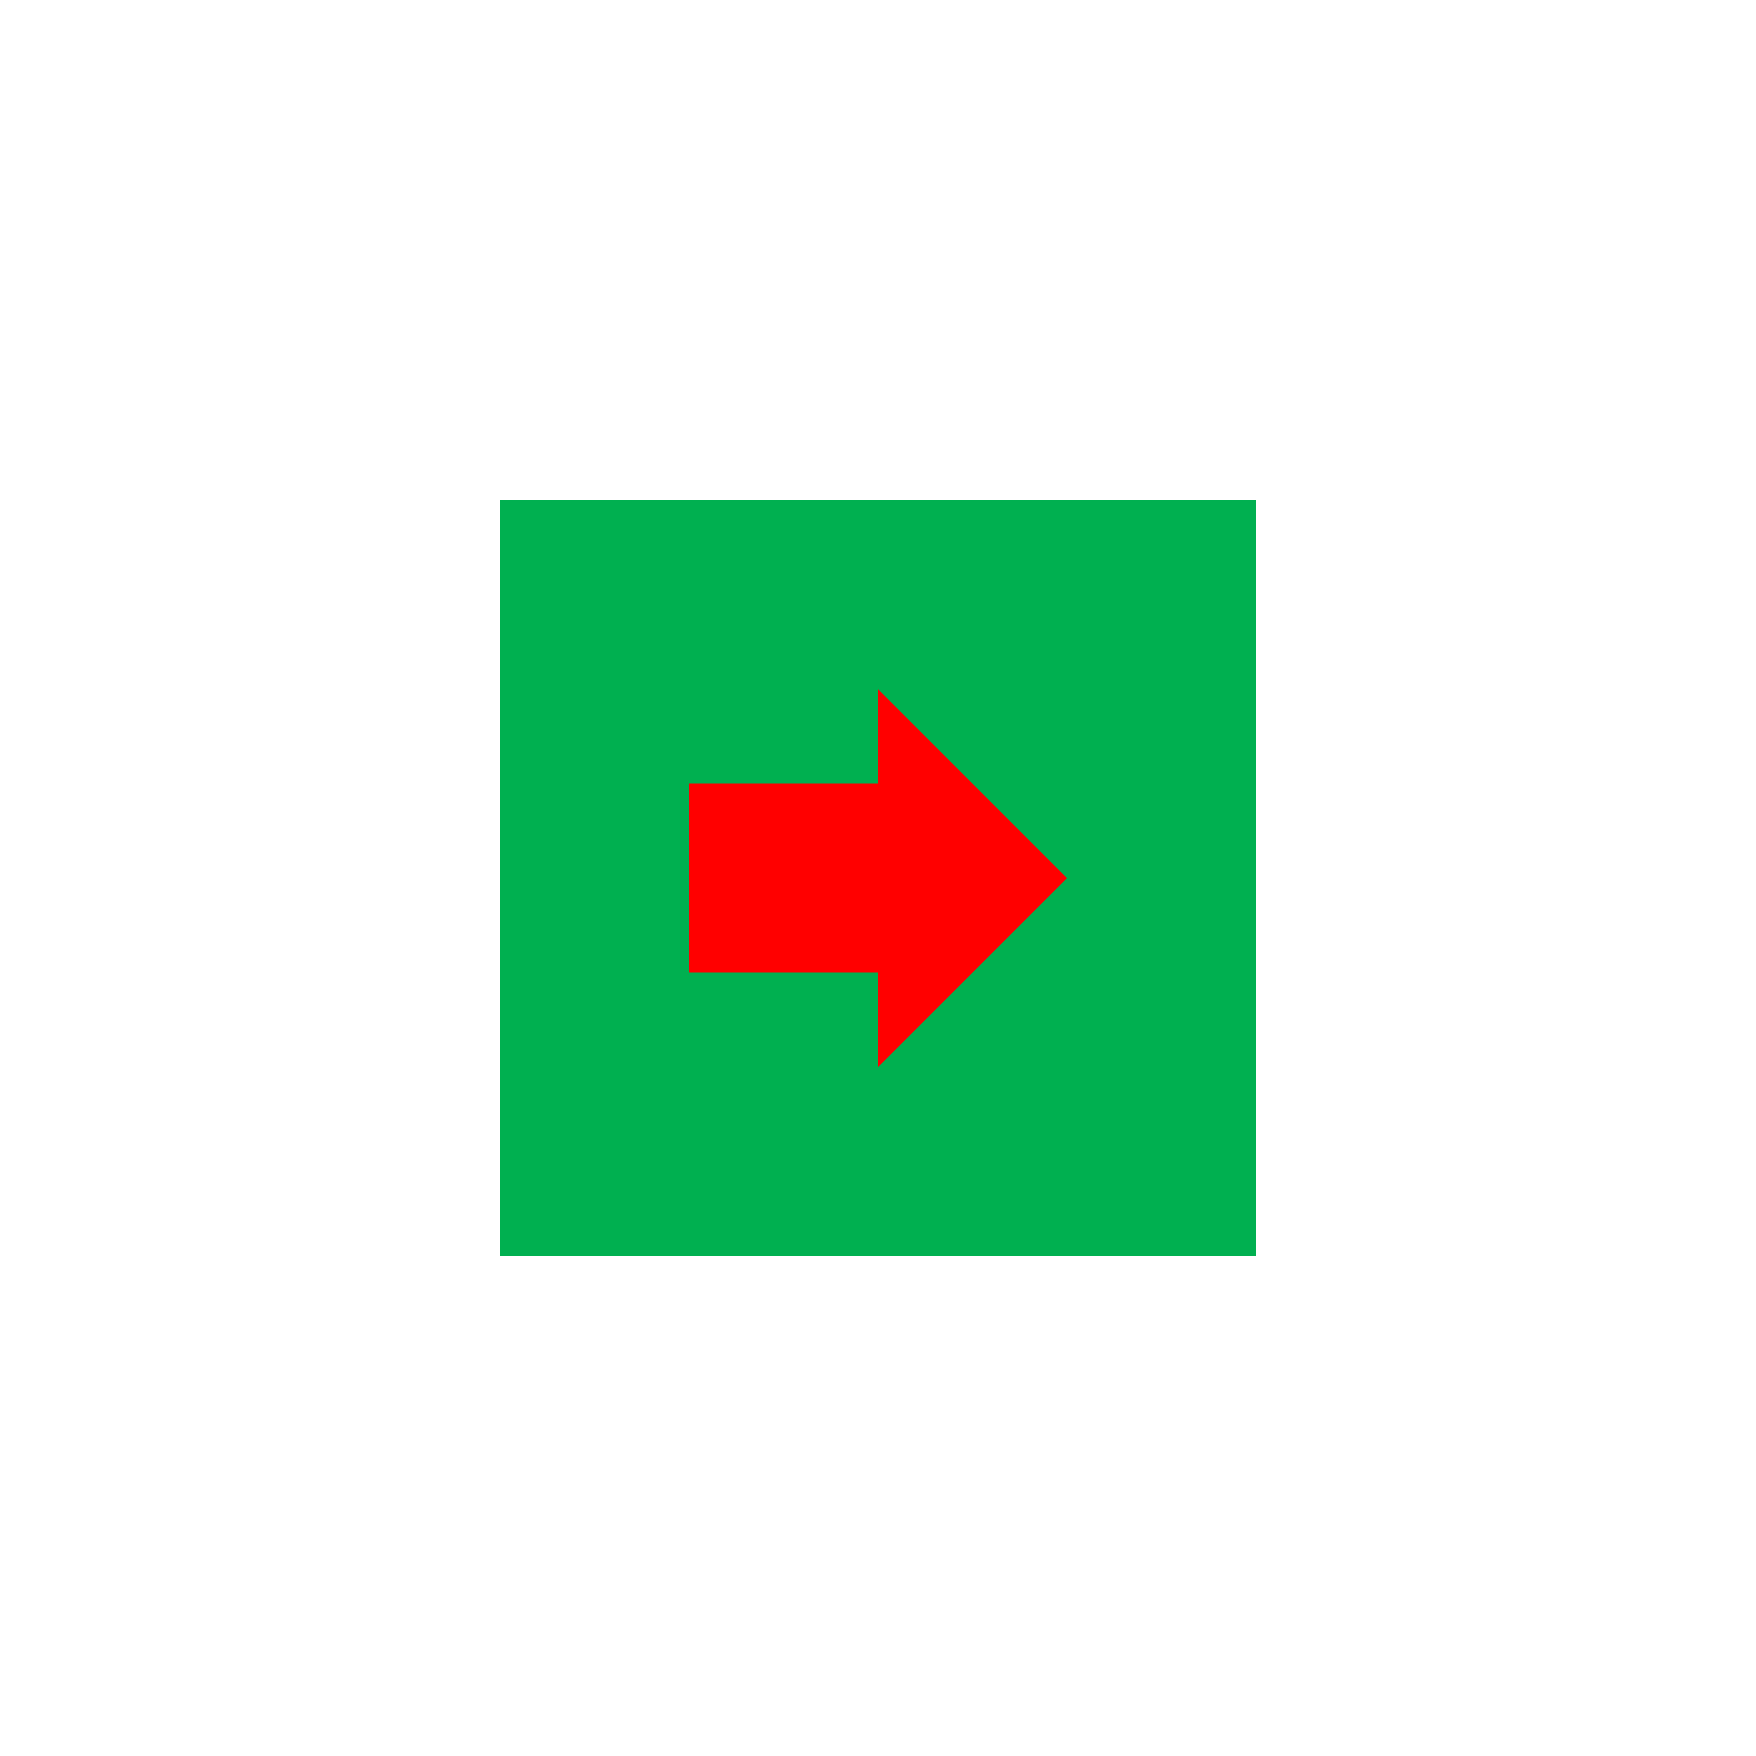

Grayscale and Threshold


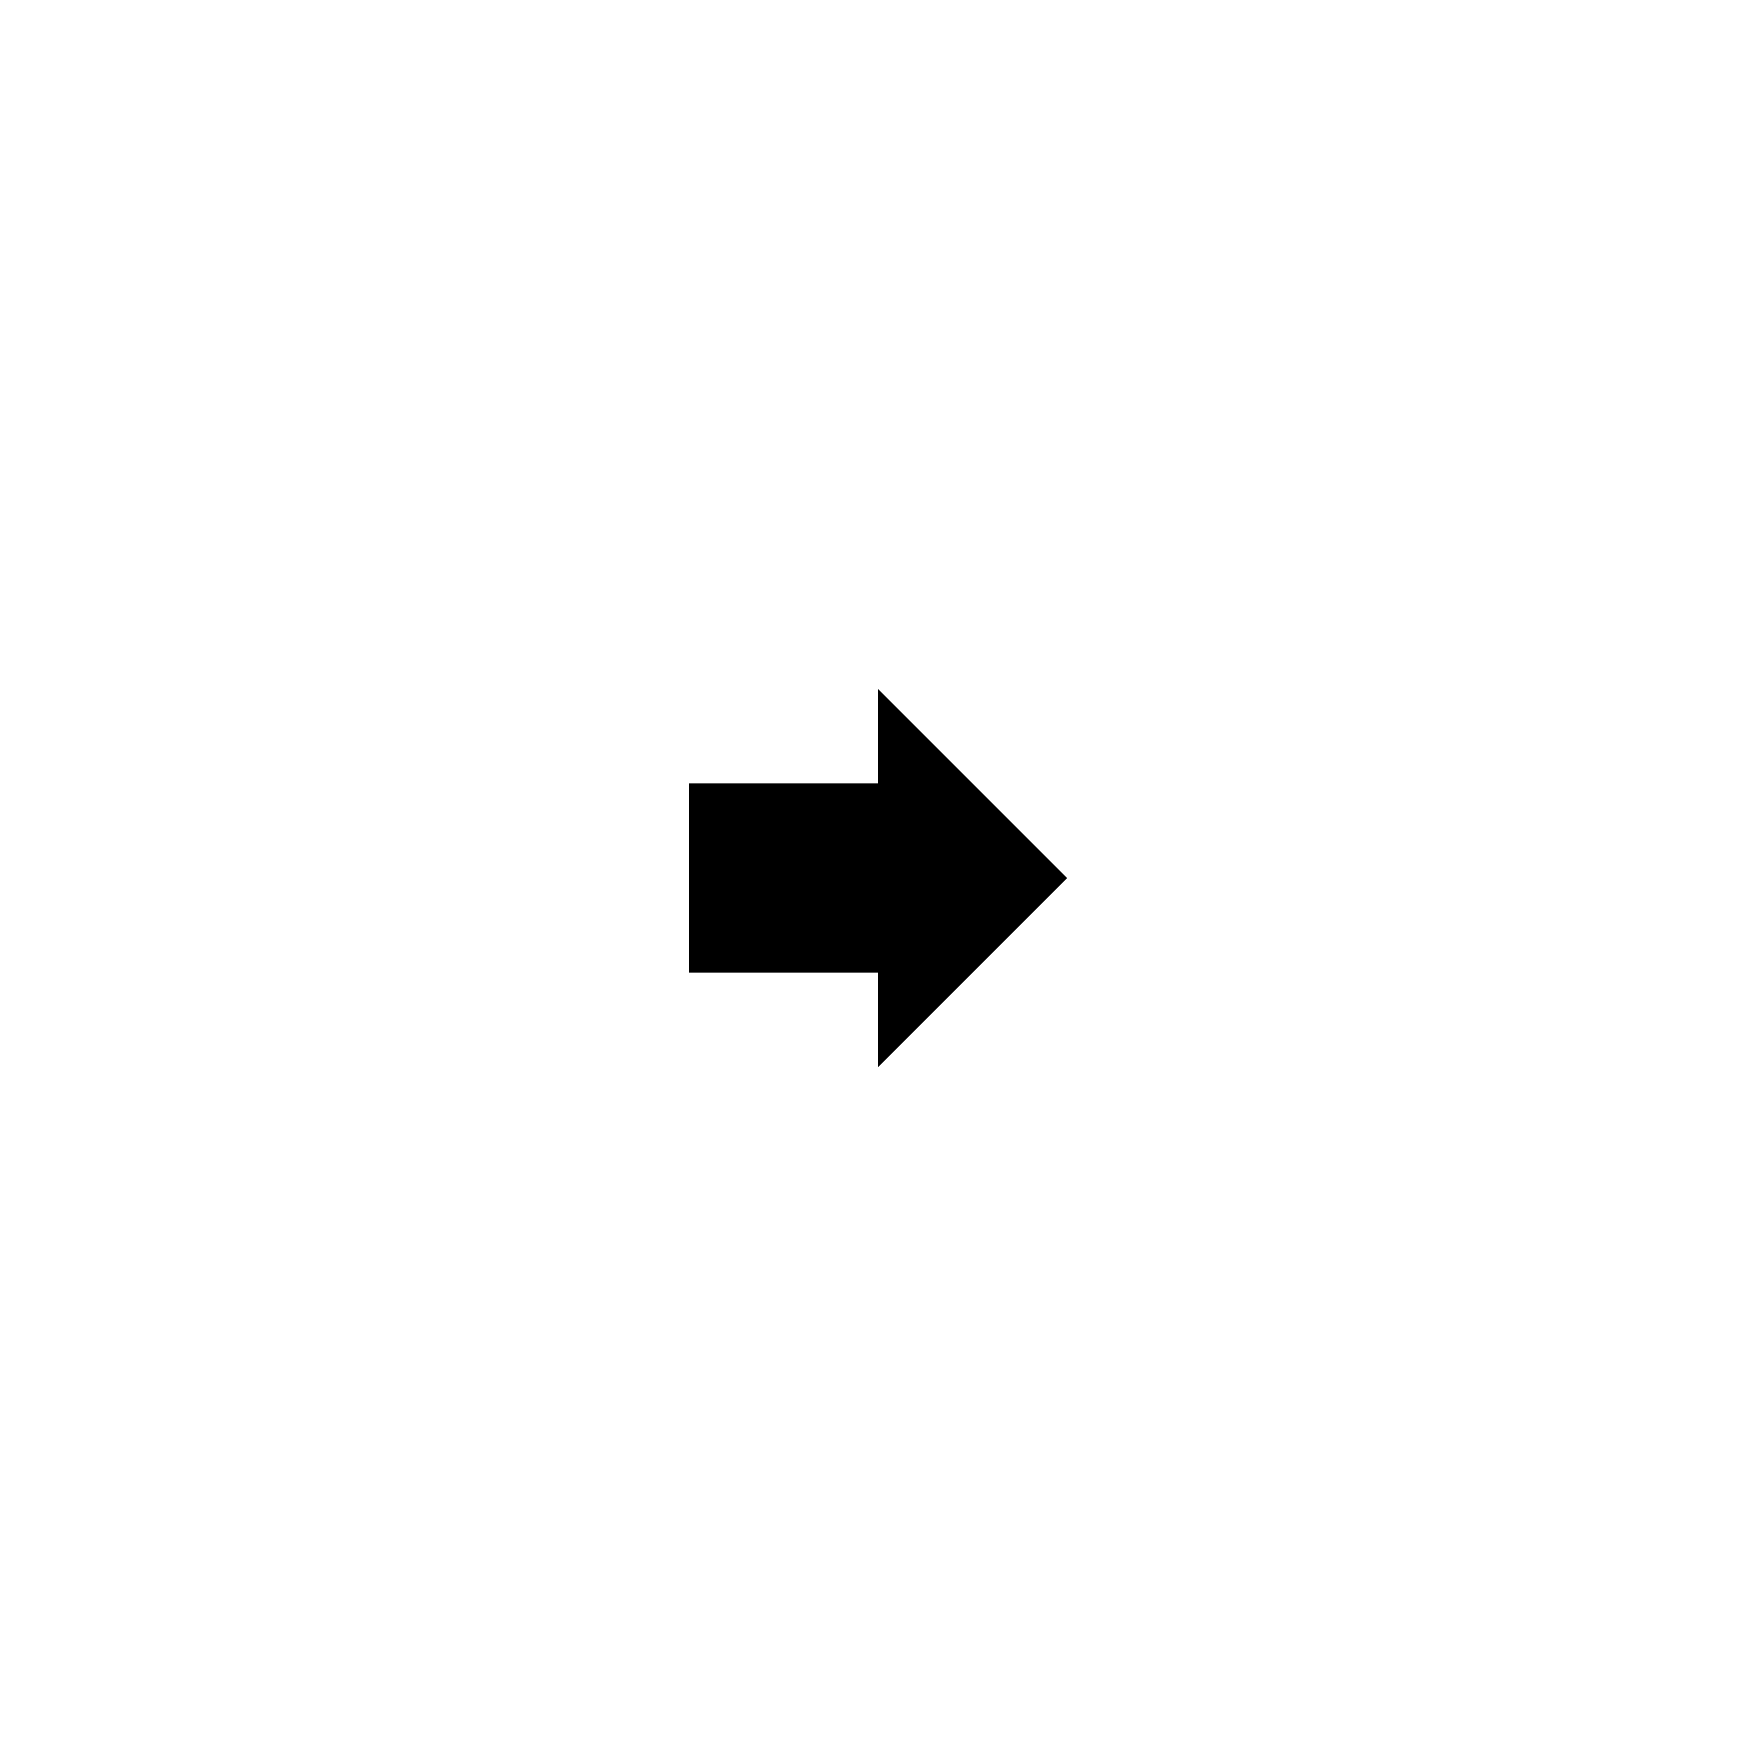

Completed


In [34]:
# @title Grayscale and Threshold { run: "auto", vertical-output: true }

from IPython.display import Image
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

# Define custom weights for RGB to grayscale conversion
def custom_rgb_to_grayscale(image, weights=[0.229, 0.587, 0.114]):
    """
    Convert a 3-channel RGB image to grayscale using custom weights.

    Parameters:
    - image (numpy.ndarray): Input RGB image.
    - weights (list): Custom weights for each RGB channel. Default is [0.229, 0.587, 0.114].

    Returns:
    - numpy.ndarray: Grayscale image.
    """
    # Ensure the image has three color channels (RGB)
    if len(image.shape) == 3 or image.shape[2] == 3\
     or len(image.shape) == 4 or image.shape[2] == 4:
      # Apply custom weights for RGB to grayscale conversion
      gray_image = np.dot(image[..., :3], weights)

    else:
      raise ValueError("Input image must be a 3-channel RGB image.")

    return gray_image

# @markdown $$ \rm{Gray} = Red \times w_1/w + Green\times w_2/w +Blue\times w_3/w $$
# @markdown $$ \rm{w} = w_1 + w_2 + w_3$$

# Custom weights for RGB to grayscale conversion
w1 = 0 # @param {type:"slider", min:0, max:1, step:0.01}
w2 = 1 # @param {type:"slider", min:0, max:1, step:0.01}
w3 = 0 # @param {type:"slider", min:0, max:1, step:0.01}
w = w1 + w2 + w3

# BGR
custom_weights = [w3/w, w2/w, w1/w]

# Display custom weights
print('Custom weights:', custom_weights)

# Current Working Directory
CWD = os.getcwd()

# File paths
file_path_cropped = f"{CWD}/tmp/cropped.png"
file_path_gray = f"{CWD}/tmp/gray.png"
file_path_threshold = f"{CWD}/tmp/threshold.png"

# Display the original color image
print('Original color image')
display(Image(file_path_cropped, width=500))

# Read the resized image
IMG = cv2.imread(file_path_cropped, cv2.IMREAD_UNCHANGED)

# Threshold parameters
threshold = 120 # @param {type:"slider", min:0, max:255, step:1}
inverse = False # @param {type:"boolean"}

# Get image dimensions
height, width = IMG.shape[:2]

# Convert image to grayscale using custom weights
IMG_GRAY = custom_rgb_to_grayscale(IMG, custom_weights)

# Apply thresholding to grayscale image
IMG_GRAY[IMG_GRAY > threshold] = 255.0

# Inverse grayscale image if specified
if inverse:
    IMG_GRAY_INVERSE = 255.0 - IMG_GRAY
    print('Input image successfully inversed')

# Remove existing grayscale and threshold images if they exist
for file_path in [file_path_gray, file_path_threshold]:
    if os.path.exists(file_path):
        os.remove(file_path)

# Save grayscale image
if inverse:
  cv2.imwrite(file_path_gray, IMG_GRAY_INVERSE)
else:
  cv2.imwrite(file_path_gray, IMG_GRAY)

# Display grayscale image
print('Grayscale and Threshold')
display(Image(file_path_gray, width=500))

print('Completed')


###2-3-1. Outline (Option)

As the boundary areas exhibit significant gradients in brightness data, applying a differentiation kernel allows for the extraction of these boundary regions. By setting the extracted boundary parts to 0 and the rest to 1, multiplying this mask with the original image creates a composite image where only the brightness data of the boundary parts is set to 0.

Outline


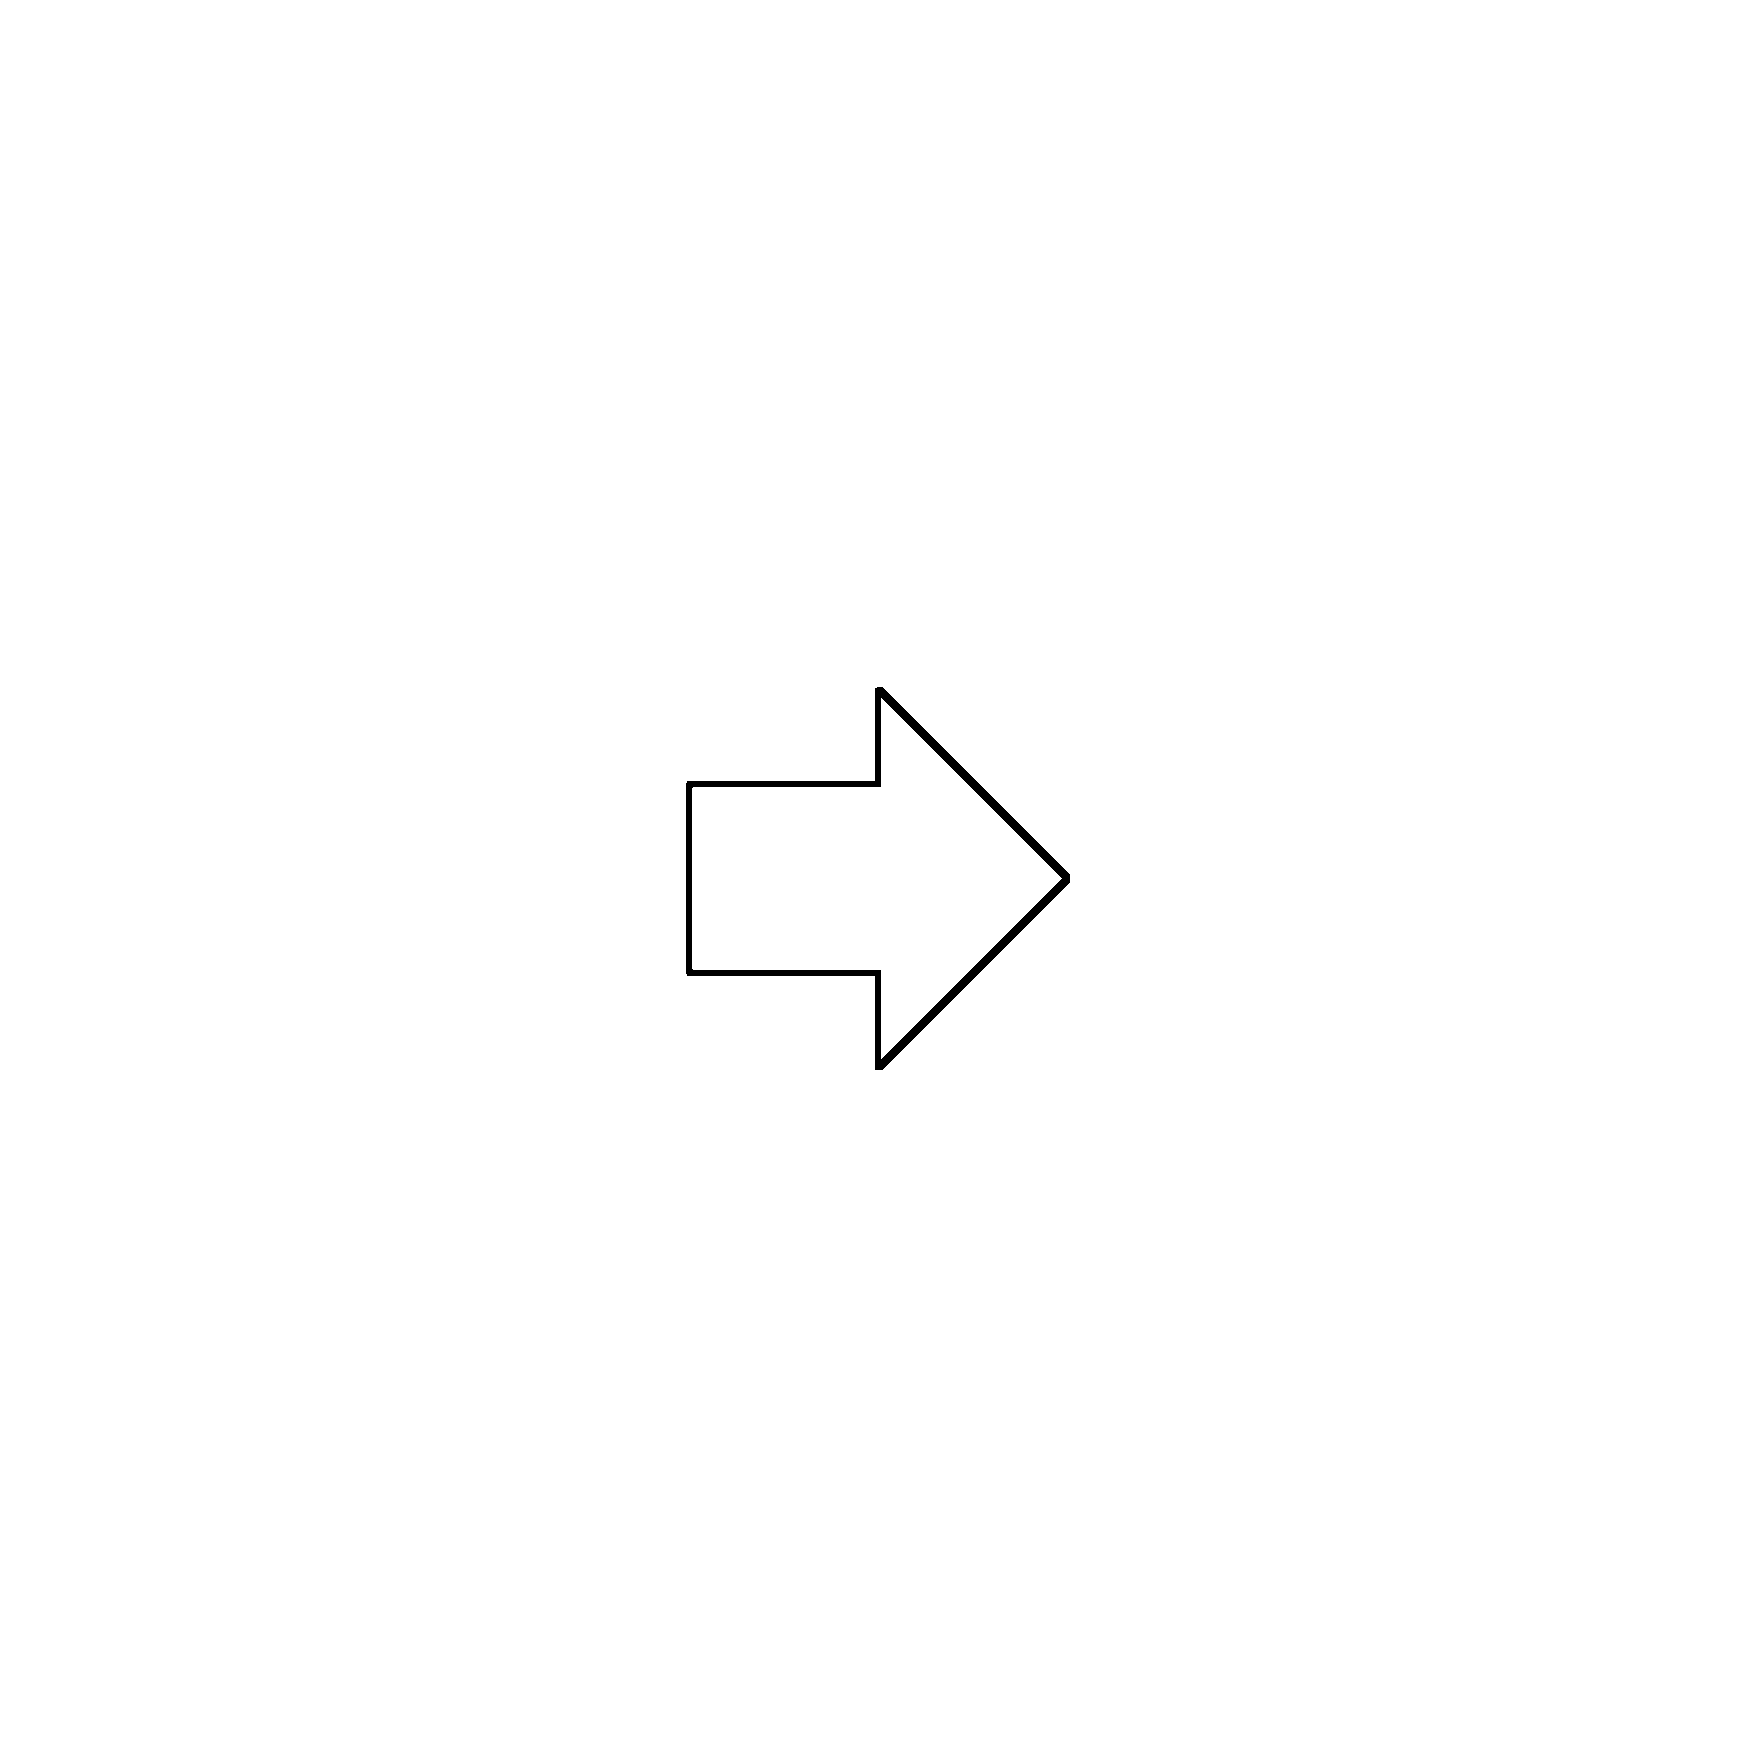

Composite image


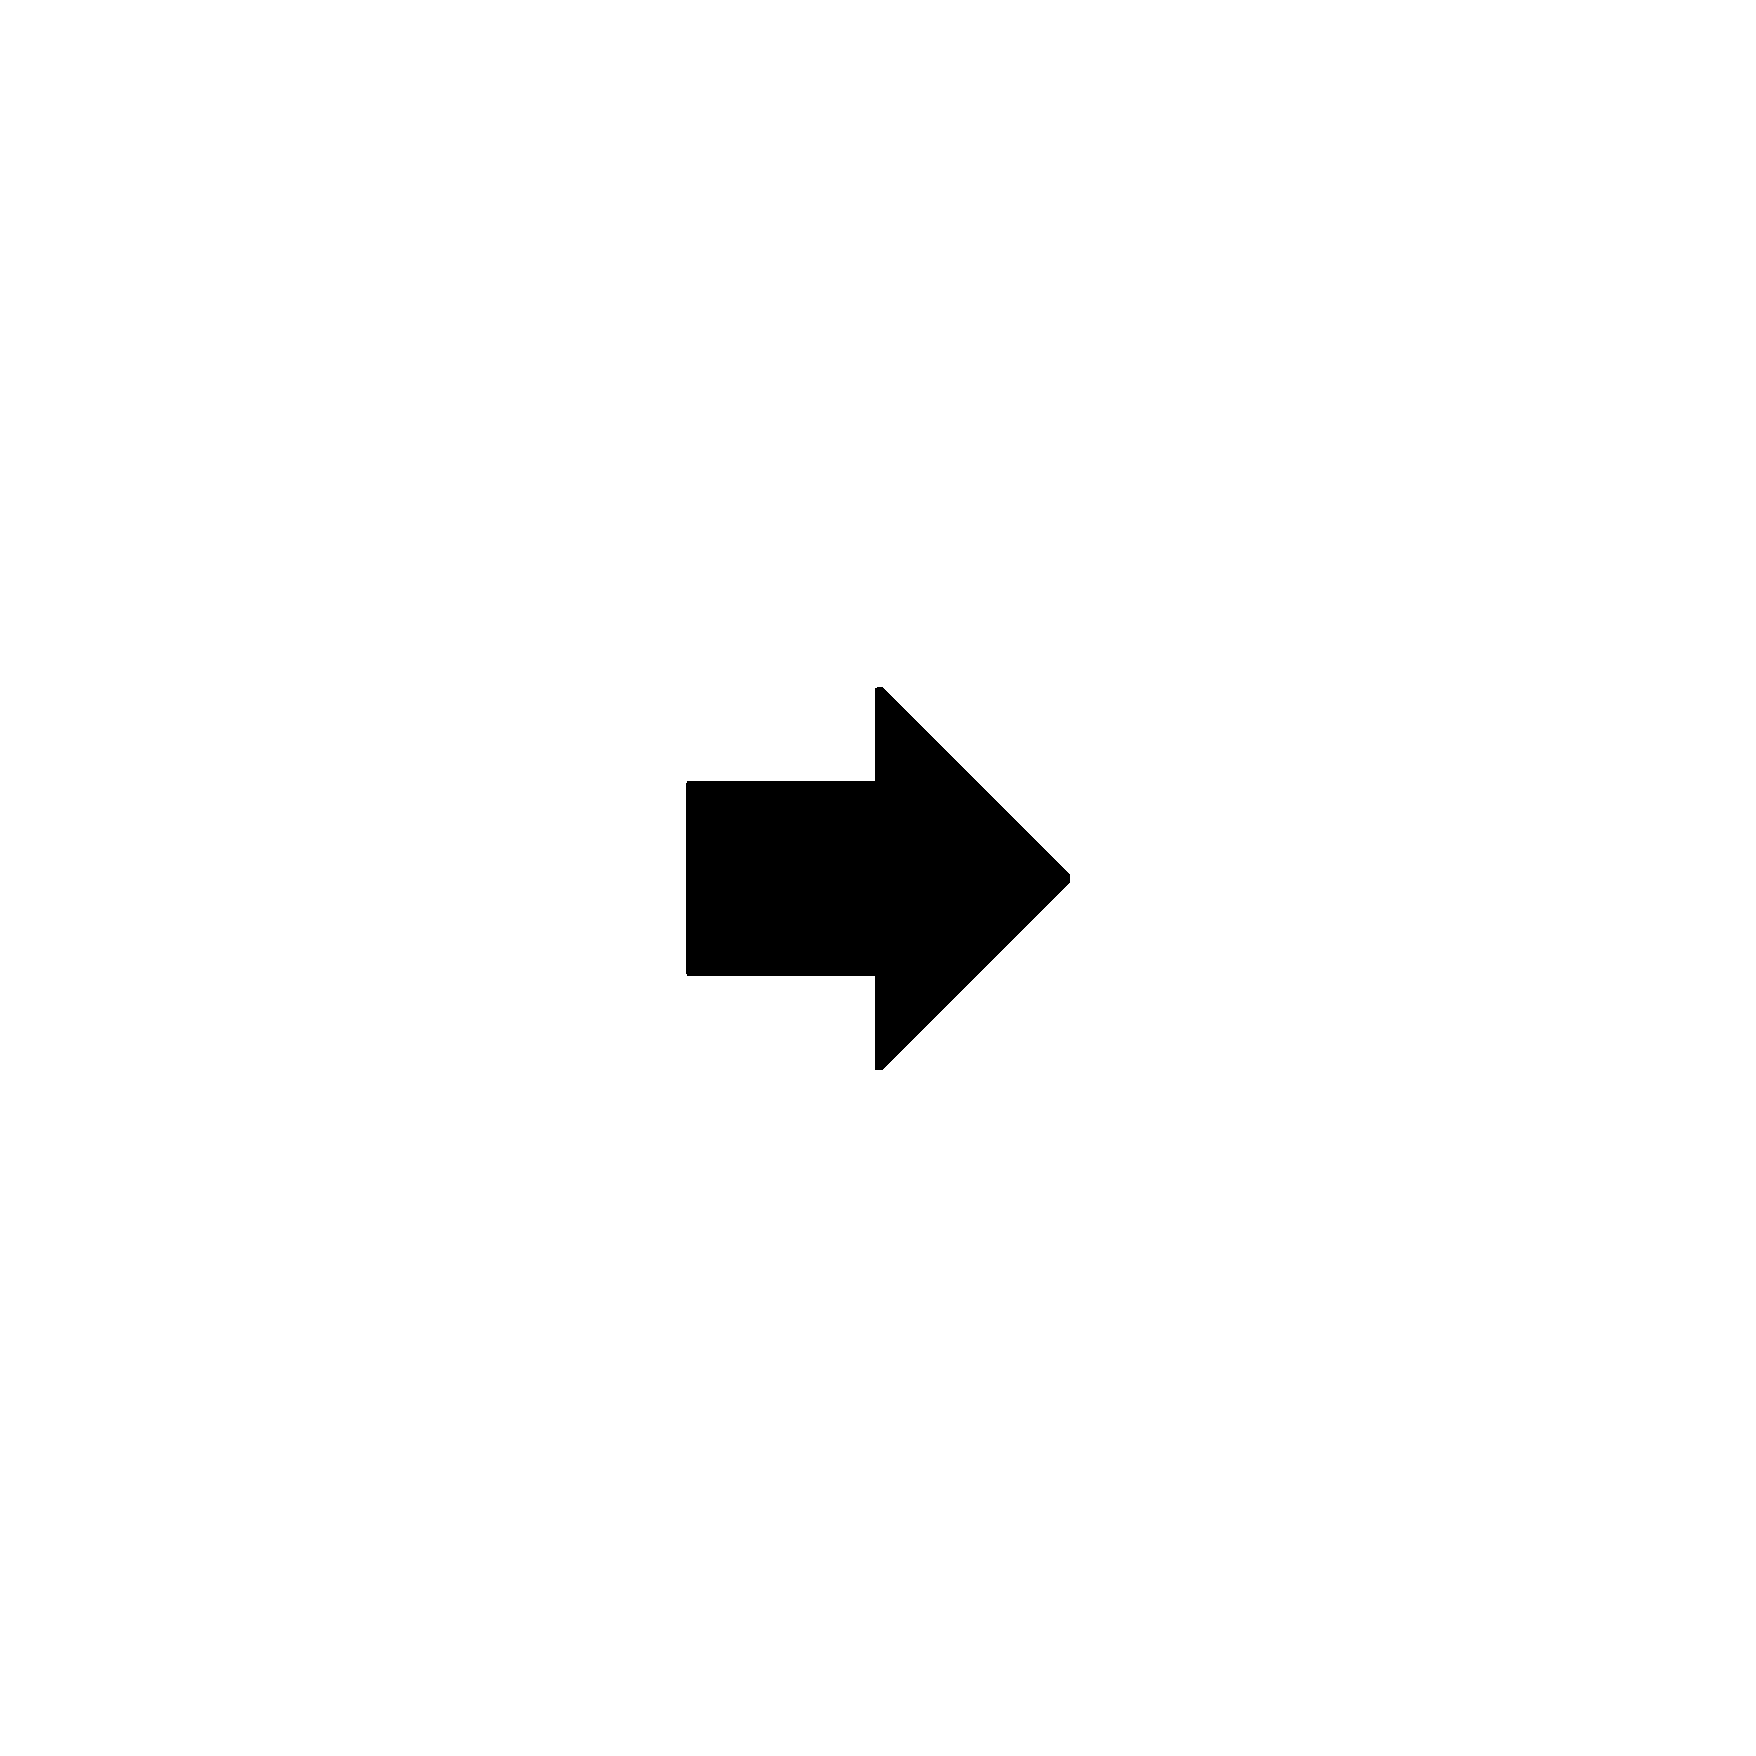

In [35]:
# @title Option: outline { run: "auto", vertical-output: true }
import cv2
import numpy as np

# Define parameters
kernel_size = 6  # @param {type:"integer"}
threshold1 = 460  # @param {type:"slider", min:0, max:500, step:1}
threshold2 = 202  # @param {type:"slider", min:0, max:500, step:1}

# Current Working Directory
CWD = os.getcwd()

# File paths
file_name_gray = f"{CWD}/tmp/gray.png"
file_name_outline = f"{CWD}/tmp/outline.png"
file_name_com = f"{CWD}/tmp/com.png"

# Read the resized image
IMG = cv2.imread(file_name_gray, cv2.IMREAD_GRAYSCALE)

# Edge detection
edges_inverse = cv2.Canny(IMG, threshold1, threshold2)

# Dilate edges to make them thicker
num_iterations = 1
kernel = np.ones((kernel_size, kernel_size), np.uint8)
edges_dilated = cv2.dilate(edges_inverse, kernel, iterations=num_iterations)

# Invert the edges and save as outline image
edges = 255.0 - edges_dilated
cv2.imwrite(file_name_outline, edges)
print('Outline')
display(Image(file_name_outline, width=500))

# Create a composite image
file_name_com = f"{CWD}/tmp/com.png"
# Normalize (0~1) edges: 0 -> black, 1 -> white
com = edges / 255.0
# Multiply the grayscale image (IMG) by the normalized edges
com = IMG * com
cv2.imwrite(file_name_com, com)
print('Composite image')
display(Image(file_name_com, width=500))


##2-4. Perform resizing and calculate fluid occupancy

1. **Resize**: Adjust the dimensions of the image using appropriate resizing techniques.

2. **Fluid Occupancy**: Determine the fluid occupancy rate by analyzing the resized image. This involves assessing the portion of the image occupied by the fluid, providing valuable insights into the fluid dynamics within the simulated environment.

###2-4-1. Resize
Resizing is done by the function `resize` of the OpenCV module. This function can scale an image by giving a scale factor. For example, a scale factor of 0.5 on a 100x100 image results in a 50x50 image.

Therefore, in order to convert an image to an arbitrary resolution, it is sufficient to know this scale factor. Let $\rm{(W, H)}$ denote the number of pixels in the original image and $\rm{(W', H')}$ the number of pixels in the converted image. Resolution is the total number of pixels, so if the original resolution is $\rm{R}$, the following equation holds.

$$ \rm{R} = WH$$

Here, the number of pixels in the height and width of the converted image $\rm{(W', H')}$ is defined using the scale factor $s( > 0)$ and $\rm{(W, H)}$ as follows.

$$ \rm{(W', H')} = (\textit{s}\rm{W}, \textit{s}\rm{H})$$

This allows the transformed resolution $\rm{R'}$ to be expressed as follows.

$$ \rm{R'} = W'H' = s^2\rm{WH} $$

Solving this for $s$, we obtain.

$$ s = \sqrt{\frac{R'}{WH}} $$

Therefore, given an arbitrary resolution, the coefficient $s$ can be obtained and resizing can be performed. Run the code block below and set the resolution by changing the slider bar of `resolution`. The last value you set will be the resolution used in the following program. The images are stored in the `tmp` folder.

###2-4-2. Fluid Occupancy


Defenition of porosity distribution:

\begin{equation}
\displaystyle \varepsilon = \frac{1}{2} \tanh(x) + \frac{1}{2},\   x = \frac{\xi}{\Delta}
\end{equation}

where $\xi$ is the distance function.

In [61]:
# @title Max Resolution Check { vertical-output: true }

# Current working directory
CWD = os.getcwd()

file_path_gray = f"{CWD}/tmp/gray.png"

# read an image resized
src = cv2.imread(file_path_gray, cv2.IMREAD_UNCHANGED)
print('Max resolution:', src.shape[0:2])

Max resolution: (1756, 1756)


SPOT DETECTED:  1131
Complete
Boundary area =  189.98
make a file for display


100%|██████████| 200/200 [00:00<00:00, 4301.94it/s]


make a porosity distribution


100%|██████████| 200/200 [00:00<00:00, 5036.72it/s]


write porosity distribution


100%|██████████| 200/200 [00:00<00:00, 1221.06it/s]


Complete


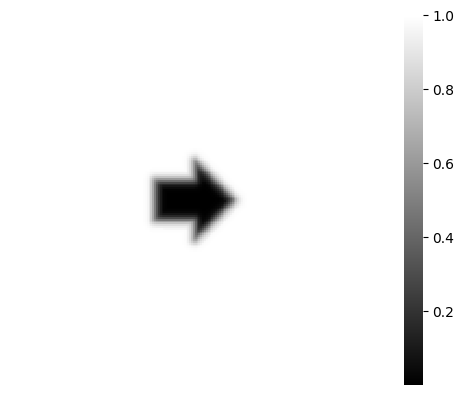

---------------- Processing Results ----------------
Setting resolution  =  40000 (200, 200)
Porosity resolution =  40000 (200, 200)
Threshold     :  120
Minimum value :  1e-06
Shade factor  :  1
Generation Type :  SDF
Boundary area =  189.9823661323299
-----------------------------------------------------


In [62]:
# @title Occupancy Generation { vertical-output: true }

import seaborn as sns
import numpy as np
import csv
import skfmm
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

resolution = 200  # @param {type: "integer"}
outline = False # @param {type:"boolean"}
generation_type = "SDF" # @param ["SDF", "GaussianBlur"]
thickness = 2.5  # @param {type:"raw"}

CWD = os.getcwd()

def CustomBlurPorosity(img, thickness, blur_type, resolution):
    # Function to apply custom blur and generate porosity
    h, w = img.shape[:2]
    scale_factor = resolution / max(h, w)

    ksize = int(thickness) + (int(thickness) + 1) % 2
    sigma = 0.8576 * thickness / scale_factor

    img_blur_median = cv2.medianBlur(img, ksize=3)

    if blur_type == 'Blur':
        img_blur = cv2.blur(img_blur_median, ksize=(ksize, ksize))
    elif blur_type == 'Gaussian':
        img_blur = cv2.GaussianBlur(img_blur_median, ksize=(ksize, ksize), sigmaX=sigma)

    img_blur_norm = img_blur / 255.0
    porosity = cv2.resize(img_blur_norm, (int(w * scale_factor), int(h * scale_factor)), cv2.INTER_LINEAR)

    return porosity, ksize

def SignedDistanceFieldPorosity(img, thickness, resolution):
    # Function to apply signed distance field method and generate porosity
    h, w = img.shape[:2]
    scale_factor = resolution / max(h, w)
    threshold = 128

    phi = np.where(img < threshold, -1, 1)

    # sns.heatmap(phi)
    # plt.axis('off')
    # file_path_phi = f"{CWD}/tmp/phi.png"
    # plt.savefig(file_path_phi)
    # plt.cla()

    sd = skfmm.distance(phi, dx=1)
    # sns.heatmap(sd)
    # plt.axis('off')
    # file_path_sd = f"{CWD}/tmp/sd.png"
    # plt.savefig(file_path_sd)
    # plt.cla()

    resized_sd = cv2.resize(sd, (int(w * scale_factor), int(h * scale_factor)), cv2.INTER_LINEAR) * scale_factor
    porosity = np.tanh(resized_sd/thickness) * 0.5 + 0.5

    return porosity

# File paths
if outline:
    file_name_input = f"{CWD}/tmp/com.png"
else:
    file_name_input = f"{CWD}/tmp/gray.png"

file_name_output = f"{CWD}/tmp/porosity_image.png"

# Read the input image
input_image = cv2.imread(file_name_input, cv2.IMREAD_UNCHANGED)

# Resize the image to the specified resolution
h, w = input_image.shape[:2]
scale_factor = resolution / max(h, w)

if generation_type == 'SDF':
    porosity = SignedDistanceFieldPorosity(input_image, thickness, resolution)
elif generation_type == 'GaussianBlur':
    porosity, ksize = CustomBlurPorosity(input_image, thickness, 'Gaussian', resolution)

# Divergence control of porosity distributions
h_resized, w_resized = porosity.shape[:2]
div = 12  # @param {type:"slider", min:0, max:255, step:1}
max_div = div / 255
spot = 0
for i in range(1, h_resized - 1):
    for j in range(1, w_resized - 1):
        n = porosity[i-1][j] - porosity[i][j]
        s = porosity[i+1][j] - porosity[i][j]
        w = porosity[i][j-1] - porosity[i][j]
        e = porosity[i][j+1] - porosity[i][j]
        if abs(n) > max_div or abs(s) > max_div or abs(w) > max_div or abs(e) > max_div:
            spot += 1
            porosity[i][j] = porosity[i-1:i+2,j-1:j+2].mean()

print('SPOT DETECTED: ', spot)
print('Complete')

S = np.sum(porosity - porosity**2)
print("Boundary area = ", format(S, ".2f"))

shade_factor = 1
small = 1.0e-6  # @param {type:"raw"}

# Initialization
data_write = np.empty((int(h_resized+1), int(w_resized)), dtype=object)
data_display = porosity

#@markdown # Porosity Distribution

print('make a file for display')
for i in tqdm(range(h_resized)):
    for j in range(w_resized):
        x = max(small, porosity[i][j] ** shade_factor)
        data_display[i][j] = x

data_write[0][0] = w_resized
data_write[0][1] = h_resized

print('make a porosity distribution')
for i in tqdm(range(h_resized)):
  for j in range(w_resized):
    data_write[i+1][j] = format(1.0, '.4E')

# Write porosity distribution
print('write porosity distribution')
for i in tqdm(range(h_resized)):
  for j in range(w_resized):
    x = max(small, porosity[i][j] ** shade_factor)
    data_write[i+1][j] = format(x, '.4E')

with open('porosity.csv', 'w', newline='') as csvfile:
    reader  = csv.writer(csvfile)
    reader.writerows(data_write)

with open('process.txt', 'w', encoding='utf-8') as f:
    print('---------------- Processing Results ----------------', file=f)
    print('Setting resolution  = ', porosity.shape[0]*porosity.shape[1], porosity.shape, file=f)
    print('Porosity resolution = ', (data_write.shape[0]-1)*data_write.shape[1], data_write[1:,:].shape, file=f)
    print('Threshold     : ', threshold, file=f)
    print('Minimum value : ', small, file=f)
    print('Shade factor  : ', shade_factor, file=f)
    print('Generation Type : ', generation_type, file=f)
    if generation_type == 'GaussianBlur':
      print('Kernel size   : ', ksize, file=f)
    print('Boundary area = ', S, file=f)
    print('-----------------------------------------------------', file=f)

print('Complete')

# Visualize porosity distribution using heatmap
sns.heatmap(data_display, cmap="gray", xticklabels=False, yticklabels=False, square=True)
plt.savefig(file_name_output)
plt.show()

# Display the content of the process.txt file
%cat process.txt


# 3. CFD

Program [2] for laminar flow calculations of the MAC algorithm using the Immersed boundary method.
### controlDict settings

A controlDict.txt file enables to change some values from it. We need not recompile the program when we change any variables because of using namelist.  
\begin{align}
&CFL = \frac{U\Delta t}{\Delta x} \leq 1 &\\
&Re = \frac{Ul}{\nu} = \frac{\rho Ul}{\mu}\\
&Pe = \frac{U\Delta x}{\nu} < 2\\
&D = \frac{\nu\Delta t}{\Delta x^2} \leq \frac{1}{2}
\end{align}

Where,  
$U$ = Inlet velocity  
$l$ = Representative length in flow direction  
$\nu$ = Kinematic viscosity  
$\mu$ = Dynamic viscosity  
$\rho$ = Density of the fluid

Large Peclet numbers mean that the advection term is dominant, which can lead to unstable calculations. As the program uses central differences, the stability condition for the Peclet number is $Pe < 2$.

## Simulation

The simulation program is written in Fortran. The `porosity.csv` generated by the above code is read in and the flow field is calculated. The calculation results are output as a file in vtk format.

In [42]:
#@title CFD PROGRAM

%%writefile main.f90
program main
!$ use omp_lib
 implicit none
 integer,parameter:: md=4500, nd=4500     ! md, nd > grid size (m,n)
 real:: dx, dy, dt
 real:: xnue, density, length, height, time, inlet_velocity, outlet_pressure, AoA, thickness
 real,dimension(0:md,0:nd):: u, v, p, u_old, v_old
 real,dimension(0:md,0:nd):: porosity
 real,dimension(0:md):: xp
 real,dimension(0:nd):: yp
 real,dimension(0:md,0:nd):: ap, ae, aw, an, as, bb
 integer:: m, n, istep, istep_max, iset, istep_out
 integer:: i, j
 real:: tp, tu, tv, tbc, ttmpout
 character(len=50) :: output_folder
 character(len=50) :: csv_file
! ----------------
! read input data by using namelist
! by Nobuto Nakamichi 4/7/2023
namelist /file_control/istep_out
namelist /grid_control/istep_max
namelist /directory_control/output_folder, csv_file
open(11,file="controlDict.txt",status="old",action="read")
read(11,nml=file_control)
read(11,nml=grid_control)
read(11,nml=directory_control)
close(11)
! ----------------
! write(*,*)'porosity setting:0 or calculation start:1 ?'
! read(*,*) iset
! make output directory

call system('mkdir -p '//trim(output_folder))
! -----------------

iset=1

!-----------------
! porosity setting

if (iset==0)then
  m=0         ! setup switch for grid conditions
  density=0.  ! setup switch for physical conditions

  call  physical_conditions (xnue, density, length, height, time &
                        , inlet_velocity, outlet_pressure, AoA, m, n)
  call  grid_conditions (xp, yp, dx, dy, dt, xnue, density, length, height, thickness, time &
                        , inlet_velocity, AoA, porosity, m, n, istep_max, iset)
  ! call  output_grid_list (xp, yp, m, n, angle_of_attack)
  stop
end if

! ----------------
! calculation start  (if iest=!0)
! ----------------
! set up condistions
m=0         ! setup switch for grid conditions
density=0.  ! setup switch for physical conditions

call  physical_conditions (xnue, density, length, height, time &
                       , inlet_velocity, outlet_pressure, AoA, m, n)
call  grid_conditions (xp, yp, dx, dy, dt, xnue, density, length, height, thickness, time &
                       , inlet_velocity, AoA, porosity, m, n, istep_max, iset)
call  output_grid (xp, yp, m, n)

! write(*,*) "check", (porosity(i,10), i=1,m)

istep = 0
time = istep * dt

! ----------------

write(*,*) 'istep_max= ', istep_max,'   istep_out= ', istep_out

call  initial_conditions (p, u, v, xp, yp, length, height &
                       , inlet_velocity, outlet_pressure, AoA, m, n)
call  boundary (p, u, v, xp, yp, length, height            &
                       , inlet_velocity, outlet_pressure, AoA, porosity, m, n)

! print initial conditions
! call  output_solution (p, u, v, m, n)

! ----------------
! MAC algorithm start

do istep = 1, istep_max

  time	=istep* dt
  write(*,*)'--- time_steps= ',istep, ' --  time = ',time

  do i = 0, m+1
    do j = 0, n+1
      u_old(i,j) = u(i,j)
      v_old(i,j) = v(i,j)
    end do
  end do

  call  solve_p (p, u, v, u_old, v_old, porosity, xnue, density, height, thickness, yp, dx, dy, dt, m, n)

  call  solve_u (p, u, v, u_old, v_old, porosity, xnue, density, dx, dy, dt, m, n)

  call  solve_v (p, u, v, u_old, v_old, porosity, xnue, density, dx, dy, dt, m, n)

  call  boundary(p, u, v, xp, yp, length, height    &
                      , inlet_velocity, outlet_pressure, AoA, porosity, m, n)
  if(mod(istep,istep_out)==0) call  output_paraview_temp (p, u, v, porosity, xp, yp, m, n, istep)


end do
! MAC algorithm end
! ----------------

! print conditions (recall)
! call  physical_conditions (xnue, density, length, height, time, inlet_velocity, outlet_pressure, m, n)
! call  grid_conditions (xp, yp, dx, dy, dt, xnue, density, length, height, time, inlet_velocity, porosity, m, n, istep_max)

! print solutions
!call  output_solution_post (p, u, v, xp, yp, porosity, m, n)
!call  output_divergent (p, u, v, porosity, dx, dy, m, n)
call  output_paraview (p, u, v, porosity, xp, yp, m, n)
write(*,*) 'program finished'

end program main
!******************

!  solve variables

!******************
subroutine  solve_p (p, u, v, u_old, v_old, porosity, xnue, density, height,thickness, yp, dx, dy, dt, m, n)
 implicit none
 integer,parameter:: md = 4500, nd = 4500     ! md, nd > grid size (m,n)
 real,intent(in):: dx, dy, dt
 real,intent(in):: xnue, density, height, thickness
 real,intent(inout),dimension(0:md,0:nd):: u, v, p, u_old, v_old
 real,intent(in),dimension(0:md,0:nd):: porosity
 real,intent(in),dimension(0:nd):: yp
 integer,intent(in):: m, n

!-----------------
! local variables
 real, parameter:: small = 1.e-6, big = 1.e6, zero = 0.
 real:: u_stg, v_stg
 real,dimension(0:md,0:nd):: ap, ae, aw, an, as, bb, div
 integer:: i, j
 real:: fc, poro_grad

!-----------------
!  divergence term  div(u)
!-----------------
! ----------------
! read input data by using namelist
! by Nobuto Nakamichi 27/7/2023
logical::nonslip
namelist /calculation_method/nonslip
open(11,file="controlDict.txt",status="old",action="read")
read(11,nml=calculation_method)
close(11)
! ----------------
do i = 1, m
do j = 1, n
div(i,j)= (u_old(i+1,j)-u_old(i-1,j))/dx*.5 + (v_old(i,j+1)-v_old(i,j-1))/dx*.5
end do
end do

do j = 1, n
div(0,j)  = 0.  ! inlet
div(m+1,j)= 0.  ! outlet
end do

do i = 1, m
div(i,0)  = div(i,n)  ! periodic condition
div(i,n+1)= div(i,1)
end do

! ----------------
fc=0.

do i = 1, m
do j = 1, n
!poro_grad= sqrt( ((porosity(i+1,j)-porosity(i-1,j))/dx/2.)**2 &
!                +((porosity(i,j+1)-porosity(i,j-1))/dy/2.)**2 )
! ----------------
!   velocity u
! ----------------
! convection_x  (1st upwind scheme)
!u(i,j)=u_old(i,j)						&
!      -dt*max(u_old(i,j),0.)*(u_old(i,j)-u_old(i-1,j))/dx	&  ! u>0 1st upwind scheme
!      -dt*min(u_old(i,j),0.)*(u_old(i+1,j)-u_old(i,j))/dx	   ! u<0 1st upwind scheme
!      -dt*u_old(i,j)*(u_old(i+1,j)-u_old(i-1,j))/dx*.5         ! 2nd central scheme (canceled)
u(i,j)=u_old(i,j)-dt*(                  &
       fc*( max(u_old(i,j),0.)*(u_old(i,j)-u_old(i-1,j))/dx	  &      ! u>0 1st upwind scheme
           +min(u_old(i,j),0.)*(u_old(i+1,j)-u_old(i,j))/dx ) &      ! u<0 1st upwind scheme
 +(1.-fc)* u_old(i,j)*(u_old(i+1,j)-u_old(i-1,j))/dx/2.       )    ! 2nd central scheme

! convection_y
!u(i,j)=u(i,j)							&
!      -dt*max(v_old(i,j),0.)*(u_old(i,j)-u_old(i,j-1))/dy	&  ! v>0 1st upwind scheme
!      -dt*min(v_old(i,j),0.)*(u_old(i,j+1)-u_old(i,j))/dy	   ! v<0 1st upwind scheme
!      -dt*v_old(i,j)*(u_old(i,j+1)-u_old(i,j-1))/dx*.5         ! 2nd central scheme (canceled)
u(i,j)=u(i,j)-dt*(						&
       fc*(max(v_old(i,j),0.)*(u_old(i,j)-u_old(i,j-1))/dy	&   ! v>0 1st upwind scheme
          +min(v_old(i,j),0.)*(u_old(i,j+1)-u_old(i,j))/dy) &   ! v<0 1st upwind scheme
 +(1.-fc)* v_old(i,j)*(u_old(i,j+1)-u_old(i,j-1))/dy/2.     ) ! 2nd central scheme

! diffusion_x
u(i,j)=u(i,j) +dt*xnue*(u_old(i+1,j)-2.*u_old(i,j)+u_old(i-1,j))/dx/dx
!      +dt*xnue/(small+porosity(i,j))*(u_old(i+1,j)-u_old(i-1,j))*(porosity(i+1,j)-porosity(i-1,j))/dx/dx*0.25 ! non-conseved term
! diffusion_y
u(i,j)=u(i,j) +dt*xnue*(u_old(i,j+1)-2.*u_old(i,j)+u_old(i,j-1))/dy/dy
!      +dt*xnue/(small+porosity(i,j))*(u_old(i,j+1)-u_old(i,j-1))*(porosity(i,j+1)-porosity(i,j-1))/dy/dy*0.25 ! non-conseved term
! divergence term
u(i,j)=u(i,j) +dt*xnue*(3./3.)*(div(i+1,j)-div(i-1,j))/dx*.5
! additional terms by porosity profile   ! canceled for non-slip condition
u(i,j)=u(i,j)							&
      +dt*( ( (u_old(i+1,j)-u_old(i-1,j))/dx*.5+(u_old(i+1,j)-u_old(i-1,j))/dx*.5) &
              *xnue*(porosity(i+1,j)-porosity(i-1,j))/dx*.5                        &
           +( (u_old(i,j+1)-u_old(i,j-1))/dy*.5+(v_old(i+1,j)-v_old(i-1,j))/dx*.5) &
              *xnue*(porosity(i,j+1)-porosity(i,j-1))/dy*.5                        &
 	       + div(i,j)*xnue*(porosity(i+1,j)-porosity(i-1,j))/dx*0.5*(-0./3.)       &
		   )/porosity(i,j)
! force on wall
if (nonslip) then
  u(i,j)=u(i,j)- dt*xnue*u_old(i,j)/(thickness*dx)**2 *32.*porosity(i,j)*(1.-porosity(i,j))*(1.-porosity(i,j))
end if
! ----------------
!   velocity v
! ----------------
! convection_x  (1st upwind scheme)
!v(i,j)=v_old(i,j)						&
!      -dt*max(u_old(i,j),0.)*(v_old(i,j)-v_old(i-1,j))/dx	&  ! u>0 1st upwind scheme
!      -dt*min(u_old(i,j),0.)*(v_old(i+1,j)-v_old(i,j))/dx	   ! u<0 1st upwind scheme
!      -dt*u_old(i,j)*(v_old(i+1,j)-v_old(i-1,j))/dx*.5         ! 2nd central scheme (canceled)
v(i,j)=v_old(i,j)-dt*(						&
      fc *(max(u_old(i,j),0.)*(v_old(i,j)-v_old(i-1,j))/dx	&  ! u>0 1st upwind scheme
          +min(u_old(i,j),0.)*(v_old(i+1,j)-v_old(i,j))/dx) &  ! u<0 1st upwind scheme
 +(1.-fc)* u_old(i,j)*(v_old(i+1,j)-v_old(i-1,j))/dx/2.     ) ! 2nd central scheme

! convection_y
!v(i,j)=v(i,j)							&
!      -dt*max(v_old(i,j),0.)*(v_old(i,j)-v_old(i,j-1))/dy	&  ! v>0
!      -dt*min(v_old(i,j),0.)*(v_old(i,j+1)-v_old(i,j))/dy	   ! v<0
!      -dt*v_old(i,j)*(v_old(i,j+1)-v_old(i-1,j-1))/dx*.5         ! 2nd central scheme (canceled)
v(i,j)=v(i,j)-dt*(							&
      fc *(max(v_old(i,j),0.)*(v_old(i,j)-v_old(i,j-1))/dy	&  ! v>0
          +min(v_old(i,j),0.)*(v_old(i,j+1)-v_old(i,j))/dy) &  ! v<0
 +(1.-fc)* v_old(i,j)*(v_old(i,j+1)-v_old(i,j-1))/dy/2.   ) ! 2nd central scheme

! diffusion_x
v(i,j)=v(i,j) +dt*xnue*(v_old(i+1,j)-2.*v_old(i,j)+v_old(i-1,j))/dx/dx
!      +dt*xnue/(small+porosity(i,j))*(v_old(i+1,j)-v_old(i-1,j))*(porosity(i+1,j)-porosity(i-1,j))/dx/dx*0.25 ! non-conseved term
! diffusion_y
v(i,j)=v(i,j) +dt*xnue*(v_old(i,j+1)-2.*v_old(i,j)+v_old(i,j-1))/dy/dy
!      +dt*xnue/(small+porosity(i,j))*(v_old(i,j+1)-v_old(i,j-1))*(porosity(i,j+1)-porosity(i,j-1))/dy/dy*0.25 ! non-conseved term
! divergence term   ! L+(2/3)N = (1/3)N;(2/3) or 0(1/3)
v(i,j)=v(i,j) +dt*xnue*(3./3.)*(div(i,j+1)-div(i,j-1))/dy*.5
! additional terms by porosity profile   ! canceled for non-slip condition    ! L+(2/3)N = (1/3)N;(-1/3) or 0:(-2/3)N
v(i,j)=v(i,j)							&
      +dt*( ( (v_old(i+1,j)-v_old(i-1,j))/dx*.5+(u_old(i,j+1)-u_old(i,j-1))/dy*.5) &
              *xnue*(porosity(i+1,j)-porosity(i-1,j))/dx*.5                        &
           +( (v_old(i,j+1)-v_old(i,j-1))/dy*.5+(v_old(i,j+1)-v_old(i,j-1))/dy*.5) &
              *xnue*(porosity(i,j+1)-porosity(i,j-1))/dy*.5                        &
	       + div(i,j)*xnue*(porosity(i,j+1)-porosity(i,j-1))/dy*0.5*(-0./3.)       &
		   )/porosity(i,j)
! force on wall
if (nonslip) then
  v(i,j)=v(i,j)- dt*xnue*v_old(i,j)/(thickness*dx)**2 *32.*porosity(i,j)*(1.-porosity(i,j))*(1.-porosity(i,j))
end if
end do
end do

! ----------------
! matrix solution  !  formulation of porous media

do i = 1, m
do j = 1, n
ae(i,j)= dt*max(small,(porosity(i+1,j)+porosity(i,j))*0.5)/dx/dx
aw(i,j)= dt*max(small,(porosity(i,j)+porosity(i-1,j))*0.5)/dx/dx
an(i,j)= dt*max(small,(porosity(i,j+1)+porosity(i,j))*0.5)/dy/dy
as(i,j)= dt*max(small,(porosity(i,j)+porosity(i,j-1))*0.5)/dy/dy
ap(i,j)= -ae(i,j)-aw(i,j)-an(i,j)-as(i,j)

bb(i,j)= ((porosity(i+1,j)*u(i,j)+porosity(i,j)*u(i+1,j))*0.5             &
         -(porosity(i-1,j)*u(i,j)+porosity(i,j)*u(i-1,j))*0.5)*density/dx &
        +((porosity(i,j+1)*v(i,j)+porosity(i,j)*v(i,j+1))*0.5             &
         -(porosity(i,j-1)*v(i,j)+porosity(i,j)*v(i,j-1))*0.5)*density/dy

!if (porosity(i,j) <small) then   !in solid (dummy solution)
! ap(i,j)=-1.
! bb(i,j)= 0.
! ae(i,j)= 0.25
! aw(i,j)= 0.25
! an(i,j)= 0.25
! as(i,j)= 0.25
!end if

end do
end do

call boundrary_matrix (p, ap, ae, aw, an, as, bb, m, n, height, yp)

!call solve_matrix (p, ap, ae, aw, an, as, bb, m, n)
call solve_matrix_vec_omp (p, ap, ae, aw, an, as, bb, m, n)
!call solve_matrix_vec_oacc (p, ap, ae, aw, an, as, bb, m, n)
! ----------------
! ----------------
return
end subroutine solve_p
!******************

!******************
! OpenACC Parallelized
! Written only for GPU machine
! No efficiency ensured on CPU machine
subroutine  solve_matrix_vec_oacc (p, ap, ae, aw, an, as, bb, m, n)
 implicit none
 integer,parameter::	md=4500, nd=4500     ! md, nd > grid size (m,n)
 real,intent(inout),dimension(0:md,0:nd)::	p
 real,intent(in),dimension(0:md,0:nd)::		ap, ae, aw, an, as, bb
 integer,intent(in)::	m, n

! local variables
real::		relux_factor, error
real,dimension(0:md, 0:nd)::	p_old
integer::	i, j, iter, iter_max, k

! ----------------
!   SOR algorithm

iter_max = min(300, max(m, n))		! SOR max interation steps
relux_factor = 1.7 	! SOR reluxation factor

!$acc data copy(p_old, p, error) &
!$acc    & copyin(ap, ae, aw, an, as, bb, relux_factor)

do iter = 1, iter_max
  ! write(*,*)'CHECK iteration no. ',iter, ' / iter_max', iter_max
  error=0.

  ! default periodic condition in y-direction
  !$acc kernels
  !$acc loop independent
  do i = 1, m
    p(i, 0) = p(i, n)
    p(i, n+1) = p(i, 1)
  end do
  !$acc end kernels

  !$acc kernels
  !$acc loop independent
  do i = 0, m+1
  !$acc loop independent
    do j = 0, n+1
      p_old(i, j) = p(i, j)
    end do
  end do
  !$acc end kernels

  !-- EVEN SPACE process
  !$acc kernels
  !$acc loop reduction(max:error)
  do k = 2, m*n, 2    ! even space
    j = (k - 1) / m + 1
    i = k - (j - 1) * m

    !-- IF m is EVEN (Based on Column-Major Order; FORTRAN)
    if(mod(m,2)==0 .and. mod(j,2)==0) i = i - 1

    p(i, j) = ( bb(i, j)					                                      &
               - ae(i, j) * p_old(i+1, j) - aw(i, j) * p_old(i-1, j)    &
               - an(i, j) * p_old(i, j+1) - as(i, j) * p_old(i, j-1) )  &
              / ap(i, j) * relux_factor                                 &
             + p_old(i, j) * (1. - relux_factor)
    error = max(error, abs(p(i, j) - p_old(i, j)))
  end do
  !$acc end kernels

  ! default periodic condition in y-direction
  !$acc kernels
  !$acc loop independent
  do i = 1, m
    p(i, 0)  = p(i, n)
    p(i, n+1) = p(i, 1)
  end do
  !$acc end kernels

  !$acc kernels
  !$acc loop independent
  do i = 0, m+1
  !$acc loop independent
    do j = 0, n+1
      p_old(i, j) = p(i, j)
    end do
  end do
  !$acc end kernels

  !-- ODD SPACE process
  !$acc kernels
  !$acc loop reduction(max:error)
  do k = 1, m*n, 2    ! odd space
    j = (k - 1) / m + 1
    i = k - (j - 1) * m

    !-- IF m is EVEN (Based on Column-Major Order; FORTRAN)
    if(mod(m,2)==0 .and. mod(j,2)==0) i = i + 1

    p(i, j) = ( bb(i, j)					                                      &
               - ae(i, j) * p_old(i+1, j) - aw(i, j) * p_old(i-1, j)    &
               - an(i, j) * p_old(i, j+1) - as(i, j) * p_old(i, j-1) )  &
              / ap(i, j) * relux_factor                                 &
             + p_old(i, j) * (1. - relux_factor)
    error = max(error, abs(p(i, j) - p_old(i, j)))
  end do
  !$acc end kernels

  !if(mod(iter,10)==0) write(*,*)'CHECK iteration no.', iter,'  -- error=', error
end do

! default periodic condition in y-direction
!$acc kernels
!$acc loop independent
do i = 1, m
  p(i, 0)   = p(i, n)
  p(i, n+1) = p(i, 1)
end do
!$acc end kernels

!$acc end data

 write(*,*)'SOR iteration no.', iter-1,'  -- error=', error
! write(*,*)' check P(10,10) in solve_matrix ', p(10,10)
! ----------------

return
end subroutine solve_matrix_vec_oacc
!******************

!******************
! OpenMP Parallelized
! Written only for CPU machine
! No efficiency ensured on GPU machine
subroutine  solve_matrix_vec_omp (p, ap, ae, aw, an, as, bb, m, n)
  implicit none
  integer,parameter::	md=4500, nd=4500     ! md, nd > grid size (m,n)
  real,intent(inout),dimension(0:md,0:nd)::	p
  real,intent(in),dimension(0:md,0:nd)::		ap, ae, aw, an, as, bb
  integer,intent(in)::	m, n

 ! local variables
 real::		relux_factor, error
 real,dimension(0:md, 0:nd)::	p_old
 real,dimension(0:md, 0:nd):: p_error
 integer::	i, j, iter, iter_max, k

 !$omp parallel private(iter, i, j, k) &
 !$omp & shared(iter_max, relux_factor, m, n) &
 !$omp & shared(error, p_old, p, ap, ae, aw, an, as, bb) &
 !$omp & default(none)

 ! ----------------
 !   SOR algorithm
 ! ----------------
 !$omp single
 iter_max = min(300, max(m, n))		! SOR max interation steps
 relux_factor = 1.7 	! SOR reluxation factor
 !$omp end single

 do iter = 1, iter_max
   ! write(*,*)'CHECK iteration no. ',iter, ' / iter_max', iter_max

   !$omp single
   error = 0.
   !$omp end single

   ! default periodic condition in y-direction
   !$omp do
   do i = 1, m
     p(i, 0) = p(i, n)
     p(i, n+1) = p(i, 1)
   end do
   !$omp end do

   !$omp do
   do i = 0, m+1
     do j = 0, n+1
       p_old(i, j) = p(i, j)
     end do
   end do
   !$omp end do

   !-- EVEN SPACE process
   !$omp do reduction(max:error)
   do k = 2, m*n, 2    ! even space
     j = (k - 1) / m + 1
     i = k - (j - 1) * m

     !-- IF m is EVEN (Based on Column-Major Order; FORTRAN)
     if(mod(m,2)==0 .and. mod(j,2)==0) i = i - 1

     p(i, j) = ( bb(i, j)					                                       &
                - ae(i, j) * p_old(i+1, j) - aw(i, j) * p_old(i-1, j)    &
                - an(i, j) * p_old(i, j+1) - as(i, j) * p_old(i, j-1) )  &
               / ap(i, j) * relux_factor                                 &
              + p_old(i, j) * (1. - relux_factor)
     error = max(error, abs(p(i, j) - p_old(i, j)))
   end do
  !$omp end do

   ! default periodic condition in y-direction
   !$omp do
   do i = 1, m
     p(i, 0)  = p(i, n)
     p(i, n+1) = p(i, 1)
   end do
   !$omp end do

   !$omp do
   do i = 0, m+1
     do j = 0, n+1
       p_old(i, j) = p(i, j)
     end do
   end do
   !$omp end do

   !-- ODD SPACE process
  !$omp do reduction(max:error)
   do k = 1, m*n, 2    ! odd space
     j = (k - 1) / m + 1
     i = k - (j - 1) * m

     !-- IF m is EVEN (Based on Column-Major Order; FORTRAN)
     if(mod(m,2)==0 .and. mod(j,2)==0) i = i + 1

     p(i, j) = ( bb(i, j)					                                       &
                - ae(i, j) * p_old(i+1, j) - aw(i, j) * p_old(i-1, j)    &
                - an(i, j) * p_old(i, j+1) - as(i, j) * p_old(i, j-1) )  &
               / ap(i, j) * relux_factor                                 &
              + p_old(i, j) * (1. - relux_factor)
     error = max(error, abs(p(i, j) - p_old(i, j)))
   end do
  !$omp end do

   !if(mod(iter,10)==0) write(*,*)'CHECK iteration no.', iter,'  -- error=', error
 end do

 ! default periodic condition in y-direction
 !$omp do
 do i = 1, m
   p(i, 0)   = p(i, n)
   p(i, n+1) = p(i, 1)
 end do
 !$omp end do

 !$omp master
  write(*,*)'SOR iteration no.', iter-1,'  -- error=', error
 ! write(*,*)' check P(10,10) in solve_matrix ', p(10,10)
 !$omp end master
 ! ----------------

 !$omp end parallel

  if (error > 1000) then
    write(*,*)'Error value diverges. Terminate the process.'
    call exit(0)
  end if

 return
 end subroutine solve_matrix_vec_omp
!******************

!******************
subroutine  solve_matrix (p, ap, ae, aw, an, as, bb, m, n)
 implicit none
 integer,parameter:: md=4500, nd=4500     ! md, nd > grid size (m,n)
 real,intent(inout),dimension(0:md,0:nd):: p
 real,intent(in),dimension(0:md,0:nd):: ap, ae, aw, an, as, bb
 integer,intent(in):: m, n

! local variables
real:: relux_factor, error
real,dimension(0:md, 0:nd):: p_old
real,dimension(0:md, 0:nd):: p_error
integer::	i, j, iter, iter_max

! ----------------
!   SOR algorithm
! ----------------
iter_max = min(100,max(m,n)) ! SOR max interation steps
relux_factor=1.7 ! SOR reluxation factor

do iter = 1, iter_max
! write(*,*)'CHECK iteration no.'
error=0.

! default periodic condition in y-direction
do i = 1, m
 p(i,0)  =p(i,n)
 p(i,n+1)=p(i,1)
end do

do i = 0, m+1
do j = 0, n+1
 p_old(i,j) = p(i,j)
end do
end do

do i = 1, m
do j = 1, n
p(i,j) = (  bb(i,j)					&
          - ae(i,j)*p_old(i+1,j) -aw(i,j)*p(i-1,j)	&
          - an(i,j)*p_old(i,j+1) -as(i,j)*p(i,j-1) )	&
         /ap(i,j)    * relux_factor			&
        + p_old(i,j) * (1.-relux_factor)

error = max(error, abs( p(i,j) - p_old(i,j) ) )
p_error(i,j) = max(p_error(i, j), abs( p(i,j) - p_old(i,j) ))
end do
end do

! debug ----------
open (41, file='p_error.csv', status='replace')
do i=1,m
  write(41,*) (p_error(i, j),",",j=1,n-1),p_error(i,n)
end do
close (41)
! ----------------

! write(*,*)'CHECK iteration no.', iter,'  -- error=', error

end do

write(*,*)'SOR iteration no.', iter-1,'  -- error=', error
if (error > 1000) then
  write(*,*)'Error value diverges. Terminate the process.'
  call exit(0)
end if

! ----------------

return
end subroutine solve_matrix
!******************

!******************
subroutine  boundrary_matrix (p, ap, ae, aw, an, as, bb, m, n, height, yp)
 implicit none
 integer,parameter::	md=4500, nd=4500     ! md, nd > grid size (m,n)
 real,intent(in)::	height
 real,intent(in),dimension(0:md,0:nd)::		p
 real,intent(inout),dimension(0:md,0:nd)::	ap, ae, aw, an, as, bb
 real,intent(in),dimension(0:nd)::		yp
 integer,intent(in)::	m, n

! local variables
integer	i, j

! ----------------
! inlet (dp/x=0 at i=1)
do j= 1, n
 ae(1,j) =ae(1,j)+aw(1,j)
 aw(1,j) =0.
end do

! outlet (p=outlet_pressure at i=m)
do j= 1, n
 bb(m,j) =bb(m,j)+ae(m,j)*p(m+1,j)
 ae(m,j) = 0.
 aw(m,j) = 0.
 an(m,j) = 0.
 as(m,j) = 0.
end do

! default : periodic condition in matrix solver

! symmetry or wall (dp/dy=0. at j=1)   xp>0
!do i= 1,m
! an(i,1) =an(i,1)+as(i,1)
! as(i,1) = 0.
!end do

! symmetry or wall  (dp/dy=0. at j=n)  xp>0
!do i= 1,m
! as(i,n) =as(i,n)+an(i,n)
! an(i,n) = 0.
!end do
! ----------------

return
end subroutine  boundrary_matrix
!******************

!******************
subroutine  solve_u (p, u, v, u_old, v_old, porosity, xnue, density, dx, dy, dt, m, n)
 implicit none
 integer,parameter::	md=4500, nd=4500     ! md, nd > grid size (m,n)
 real,intent(in)::	dx, dy, dt
 real,intent(in)::	xnue, density
 real,intent(inout),dimension(0:md,0:nd)::	u, v, p, u_old, v_old
 real,intent(in),dimension(0:md,0:nd)::	porosity
 integer,intent(in)::	m, n

! local variables
integer::	i, j

! ----------------
do i = 1, m
do j = 1, n
! convection_x  (1st upwind scheme)
! (already calculated in solve_p)

! convection_y
! (already calculated in solve_p)

! diffusion_x
! (already calculated in solve_p)

! diffusion_y
! (already calculated in solve_p)

! pressure
u(i,j)=u(i,j) -dt/density*(p(i+1,j)-p(i-1,j))/dx*0.5

end do
end do

! ----------------
return
end subroutine solve_u
!******************

!******************
subroutine  solve_v (p, u, v, u_old, v_old, porosity, xnue, density, dx, dy, dt, m, n)
 implicit none
 integer,parameter::	md=4500, nd=4500     ! md, nd > grid size (m,n)
 real,intent(in)::	dx, dy, dt
 real,intent(in)::	xnue, density
 real,intent(inout),dimension(0:md,0:nd)::	u, v, p, u_old, v_old
 real,intent(in),dimension(0:md,0:nd)::	porosity
 integer,intent(in)::	m, n

! local variables
integer::	i, j

! ----------------
do i = 1, m
do j = 1, n
! convection_x  (1st upwind scheme)
! (already calculated in solve_p)

! convection_y
! (already calculated in solve_p)

! diffusion_x
! (already calculated in solve_p)

! diffusion_y
! (already calculated in solve_p)

! pressure
v(i,j)=v(i,j) -dt/density*(p(i,j+1)-p(i,j-1))/dy*.5

end do
end do
! ----------------
return
end subroutine solve_v
!******************

!  conditions

!******************
subroutine  boundary(p, u, v, xp, yp, length, height    &
                     , inlet_velocity, outlet_pressure, AoA, porosity, m, n)
 implicit none
 integer,parameter::	md=4500, nd=4500     ! md, nd > grid size (m,n)
 real,intent(in)::	length, height, inlet_velocity, outlet_pressure, AoA
 real,intent(inout),dimension(0:md,0:nd)::	u, v, p
 real,intent(in),dimension(0:md,0:nd)::	porosity
 real,intent(in),dimension(0:md)::		xp
 real,intent(in),dimension(0:nd)::		yp
 integer,intent(in)::	m, n

! local variables
 real, parameter::     small=1.e-6, big=1.e6, zero=0., pai=atan(1.)*4.
 integer	i, j

! ----------------
! inlet (u=inlet_velocity, v=0., dp/dx=0 at i=1)
do j= 1, n
 u(1,j) =inlet_velocity*cos(AoA/180.*pai)
 v(1,j) =inlet_velocity*sin(AoA/180.*pai)
 u(0,j) =u(1,j)		! dummy
 v(0,j) =v(1,j)  	! dummy
 p(0,j) =p(2,j)
end do

! outlet (du/dx=0., dv/dx=0., p=outlet_pressure at i=m)
do j= 1, n
 u(m+1,j) =u(m-1,j)
 v(m+1,j) =v(m-1,j)
! p(m,j) =outlet_pressure
 p(m+1,j)=outlet_pressure   ! dummy
end do

! default: periodic condition (y-direction at j=1 & n)
do i= 0, m+1
 u(i,0)   = u(i,n)
 v(i,0)   = v(i,n)
 p(i,0)   = p(i,n)
 u(i,n+1) = u(i,1)
 v(i,n+1) = v(i,1)
 p(i,n+1) = p(i,1)
end do

! option: lower wall (u=0., v=0., dp/dy=0. at j=1)
!do i= 0, m+1
! u(i,1) =0.
! v(i,1) =0.
! u(i,0) =0.					! dummy
! v(i,0) = -v(i,2)		  	! dummy
! p(i,0) =p(i,2)
!end do

! option: symmetry (du/dy=0., v=0., dp/dy=0. at j=1)  xp>0
!do i= 1, m
! u(i,0) = u(i,2)
! v(i,1) =0.
! v(i,0) = -v(i,2)		  	! dummy
! p(i,0) =p(i,2)
!end do

! option: symmetry  (du/dy=0., v=0., dp/dy=0. at j=n)   xp>0
!do i= 1, m
! u(i,n+1) = u(i,n-1)
! v(i,n) =0.
! v(i,n+1) = -v(i,n-1)		! dummy
! p(i,n+1) =p(i,n-1)
!end do
! ----------------
!do i= 0, m+1
!do j= 0, n+1
!if (porosity(i,j) <small) then   !in solid (dummy solution)
! u(i,j) = 0.
! v(i,j) = 0.
!end if
!end do
!end do

return
end subroutine boundary
!*****************************

!*****************************
subroutine physical_conditions(xnue, density, length, height, time &
                              , inlet_velocity, outlet_pressure, AoA, m, n)
 implicit none
 integer,parameter:: md=4500, nd=4500     ! md, nd > grid size (m,n)
 real,intent(inout):: xnue, density, length, height, time  &
                       ,inlet_velocity, outlet_pressure, AoA
 integer,intent(in):: m, n
! local variables
 real:: reynolds_no, wing_length
 integer:: i, j

! ----------------

! ----------------
! read input file
! by Nobuto Nakamichi 4/7/2023
namelist /physical/xnue, density, length, height, time  &
                 ,inlet_velocity, outlet_pressure, AoA

if (density == 0.)then

  open(11,file="controlDict.txt",status="old",action="read")
  read(11,nml=physical)
  close(11)

end if

! ----------------

!wing_length =1.    ! (m)
!reynolds_no=wing_length*inlet_velocity/xnue

write(*,*)
write(*,*) 'xnue ='	, xnue
write(*,*) 'density ='	, density
write(*,*) 'length ='	, length
write(*,*) 'height ='	, height
write(*,*) 'time ='	, time
write(*,*) 'inlet_velocity ='	, inlet_velocity
write(*,*) 'outlet_pressure ='	, outlet_pressure
write(*,*) 'Angle of inlet_velocity (AoA) ='	, AoA
!write(*,*) 'reynolds_no='	, reynolds_no

! ----------------

return
end subroutine physical_conditions
!******************

!******************
subroutine  grid_conditions (xp, yp, dx, dy, dt, xnue, density, length, height, thickness, time &
                            , inlet_velocity, AoA, porosity, m, n, istep_max, iset)
 implicit none
 integer,parameter::	md=4500, nd=4500     ! md, nd > grid size (m,n)
 real,intent(inout)::	dx, dy, dt, AoA, thickness
 real,intent(in)::	xnue, density, length, height, time, inlet_velocity
 real,intent(inout),dimension(0:md,0:nd):: porosity
 real,intent(inout),dimension(0:md):: xp
 real,intent(inout),dimension(0:nd):: yp
 integer,intent(inout):: m, n, istep_max, iset
 character(len = 50) :: csv_file
 character(len = 50) :: output_folder

! local variables
!real,dimension(0:md,0:nd)::	distance
real:: cfl_no, pecret_no, diffusion_factor, reynolds_no
real:: pai, distance, center_x, center_y, radius
integer::	i, j
real, parameter::     small=1.e-6, big=1.e6, zero=0.
! ---

! ----------------
! namelist
! by Nobuto Nakamichi 4/7/2023
namelist /grid_control/istep_max
namelist /porosity_control/thickness
namelist /directory_control/csv_file, output_folder
open(11,file="controlDict.txt",status="old",action="read")
read(11,nml=grid_control)
read(11,nml=porosity_control)
read(11,nml=directory_control)
close(11)
!-----------------

! read pixel data
open(52,file=csv_file, form='formatted')

read(52,*) m,n

do j=1,n
 read(52,*)(porosity(i,j),i=1,m)
end do

close(52)

! thickness = 2.5
dx = length / real(m-1)
dy = height / real(n-1)
dt = time / real(istep_max)

radius = 0.25 * height

cfl_no           = inlet_velocity * dt / dx
pecret_no        = inlet_velocity * dx / xnue
diffusion_factor = xnue * dt / dy / dy
reynolds_no      = radius * inlet_velocity / xnue

!----- check print out
write(*,*)
write(*,*) 'm, n =', m, n
write(*,*) 'istep_max =', istep_max
write(*,*) 'dx, dy =', dx, dy
write(*,*) 'dt =', dt
write(*,*) 'cfl_no =', cfl_no
write(*,*) 'pecret_no =', pecret_no
write(*,*) 'diffusion_factor =', diffusion_factor
write(*,*) 'reynolds_no=' , reynolds_no
write(*,*) 'thickness =', thickness

do i = 0, m+1
 xp(i) = dx * real(i-1) - length*0.5
end do

do j = 0, n+1
 yp(j) = dy * real(j-1) - height*0.5
end do

! set porosity (fluid area difinition) by distance function data
!

! set porosity (fluid area difinition)
! pai=atan(1.0)*4.
! center_x=0.*length
! center_y=0.*height

do i = 1, m
do j = 1, n
! distance=(sqrt((xp(i)-center_x)**2+(yp(j)-center_y)**2)-radius)
! porosity(i,j) = max(small, 0.5*tanh(distance/(thickness*dx))+0.5)
! porosity(i,j) = 0.5*tanh(distance/(thickness*dx))*(1.-small*1.)+0.5*(1.+small*1.)
porosity(i,j) = max(small, porosity(i,j))
end do
end do

! default: far field condtion in x-direction
!do j = 1, n
! porosity(0,j)   = 1.
! porosity(m+1,j) = 1.
!end do

! default: outlet condtion in x-direction
do j = 1, n+1
 porosity(0,j) = porosity(1,j)
 porosity(m+1,j) = porosity(m,j)
end do

! default: periodic condtion in y-direction
do i = 0, m+1
 porosity(i,0)   = porosity(i,n)
 porosity(i,n+1) = porosity(i,1)
end do

! ----------------
return
end subroutine  grid_conditions
!******************

!******************
subroutine  initial_conditions (p, u, v, xp, yp, length, height  &
                               , inlet_velocity, outlet_pressure, AoA, m, n)
 implicit none
 integer,parameter::	md=4500, nd=4500     ! md, nd > grid size (m,n)
 real,intent(in)::	length, height, inlet_velocity, outlet_pressure, AoA
 real,intent(out),dimension(0:md,0:nd)::	u, v, p
 real,intent(in),dimension(0:md)::		xp
 real,intent(in),dimension(0:nd)::		yp
 integer,intent(in)::	m, n

! local variables
integer::	i, j
real, parameter :: pai=atan(1.)*4.

! ----------------
do j = 1, n
do i = 1, m
 u(i,j)=inlet_velocity*cos(AoA/180*pai)
 v(i,j)=inlet_velocity*sin(AoA/180*pai)
 p(i,j)=outlet_pressure
end do
end do
! ----------------

return
end subroutine initial_conditions
!******************

! output

!******************
subroutine  output_solution (p, u, v, m, n)
 implicit none
 integer,parameter::	md=4500, nd=4500     ! md, nd > grid size (m,n)
 real,intent(in),dimension(0:md,0:nd)::	u, v, p
 integer,intent(in)::	m, n

! local variables
integer::	i, j

! ----------------
write(*,*)

write(*,*)'velocity u '
do j = 0, n+1
write(*,*) (u(i,j), i=0,m+1)
end do
write(*,*)

write(*,*)'velocity v '
do j = 0, n+1
write(*,*) (v(i,j), i=0,m+1)
end do
write(*,*)

write(*,*)'pressure'
do j = 0, n+1
write(*,*) (p(i,j), i=0,m+1)
end do
write(*,*)
! ----------------

return
end subroutine output_solution
!******************

!******************
subroutine  output_grid (xp, yp, m, n)
 implicit none
 integer,parameter::	md=4500, nd=4500     ! md, nd > grid size (m,n)
 real,intent(in),dimension(0:md)::	xp
 real,intent(in),dimension(0:nd)::	yp
 integer,intent(in)::	m, n

! local variables
integer::	i, j

open (60, file='grid.dat', status='replace')
! ----------------
write(60,*)'m, n =', m, n
write(60,*)'grid points ='
write(60,*) (xp(i), i=1,m)
write(60,*) (yp(j), j=1,n)
! ----------------
close (60)
return
end subroutine output_grid
!******************

!******************
subroutine  output_grid_list (xp, yp, m, n, angle_of_attack)
 implicit none
 integer,parameter::	md=4500, nd=4500     ! md, nd > grid size (m,n)
 real,intent(in),dimension(0:md)::	xp
 real,intent(in),dimension(0:nd)::	yp
 integer,intent(in)::	m, n
 real,intent(in):: angle_of_attack

! local variables
integer::	i, j
real::      z=0.0, pai=atan(1.)*4.
real::      x, y, th

open (60, file='cellcenter.dat', status='replace')
! ----------------
th = angle_of_attack/180.*pai
do i=1,m
do j=1,n
 x=xp(i)*cos(th)-yp(j)*sin(th)
 y=xp(i)*sin(th)+yp(j)*cos(th)
 write(60,*) x,y,z
end do
end do
! ----------------
close (60)
return
end subroutine output_grid_list
!******************

!******************
subroutine  output_solution_post (p, u, v, xp, yp, porosity, m, n)
 implicit none
 integer,parameter::	md=4500, nd=4500     ! md, nd > grid size (m,n)
 real,intent(in),dimension(0:md,0:nd)::	u, v, p
 real,intent(in),dimension(0:md,0:nd)::	porosity
 real,intent(in),dimension(0:md)::	xp
 real,intent(in),dimension(0:nd)::	yp
 integer,intent(in)::	m, n

! local variables
 real, parameter::     small=1.e-6, big=1.e6, zero=0.
 real, parameter::     pmin=0.25, pmax=0.75
 integer::	i, j
 real,dimension(0:md, 0:nd)::	u_cnt, v_cnt, p_cnt

open (61, file='solution_uvp.dat', status='replace')

! ----------------
! interpolation at p-center grid

do i = 1, m
do j = 1, n
 u_cnt(i,j)=u(i,j)*porosity(i,j)
 v_cnt(i,j)=v(i,j)*porosity(i,j)
 if (porosity(i,j) > small)then
  p_cnt(i,j)=p(i,j)
 else
  p_cnt(i,j)=zero
 end if
end do
end do

do j = 1, n
 u_cnt(0,j)=u_cnt(1,j)
 v_cnt(0,j)=v_cnt(1,j)
 p_cnt(0,j)=p_cnt(1,j)
 u_cnt(m+1,j)=u_cnt(m,j)
 v_cnt(m+1,j)=v_cnt(m,j)
 p_cnt(m+1,j)=p_cnt(m,j)
end do

do i = 0, m+1
 u_cnt(i,0)=u_cnt(i,1)
 v_cnt(i,0)=v_cnt(i,1)
 p_cnt(i,0)=p_cnt(i,1)
 u_cnt(i,n+1)=u_cnt(i,n)
 v_cnt(i,n+1)=v_cnt(i,n)
 p_cnt(i,n+1)=p_cnt(i,n)
end do

!-----------------
write(61,*)'m, n =', m, n

write(61,*)'velocity u_bulk '
do j = 1, n
write(61,*) (u_cnt(i,j), i=1,m)
end do

write(61,*)'velocity v_bulk '
do j = 1, n
write(61,*) (v_cnt(i,j), i=1,m)
end do

write(61,*)'velocity u_inst '
do j = 1, n
write(61,*) (u(i,j), i=1,m)
end do

write(61,*)'velocity v_inst '
do j = 1, n
write(61,*) (v(i,j), i=1,m)
end do

write(61,*)'pressure p_fluid'
do j = 1, n
write(61,*) (p_cnt(i,j), i=1,m)
end do

write(61,*)'pressure P_all'
do j = 1, n
write(61,*) (p(i,j), i=1,m)
end do

write(61,*)'porosity'
do j = 1, n
write(61,*) (porosity(i,j), i=1,m)
end do

!write(*,*) "check", (porosity(i,10), i=1,m)

close (61)
! ----------------

! ----------------
! surface profile
open (62, file='surface_profile.dat', status='replace')

do j=1,n
do i=1,m

if( porosity(i,j) < pmax .and. porosity(i,j)>pmin )then
 write(62,*) xp(i), yp(j), p_cnt(i,j), porosity(i,j)
end if

end do
end do
close (62)
! ----------------


return
end subroutine output_solution_post
!******************

!******************
subroutine  output_paraview (p, u, v, porosity, xp, yp, m, n)
 implicit none
 integer,parameter::	md=4500, nd=4500     ! md, nd > grid size (m,n)
 real,intent(in),dimension(0:md)::	xp
 real,intent(in),dimension(0:nd)::	yp
 real,intent(in),dimension(0:md, 0:nd)::	u, v, p
 real,intent(in),dimension(0:md,0:nd)::	porosity
 integer,intent(in)::	m, n
 integer::	i, j

! local variables
 real,dimension(0:md,0:nd):: div

 character(len=50)::csv_file
 character(len=50)::output_folder

 namelist /directory_control/csv_file, output_folder
 open(11,file="controlDict.txt",status="old",action="read")
 read(11,nml=directory_control)
 close(11)

open(50,file=trim(output_folder)//'/output_paraview.vtk',status="unknown",form="formatted",position="rewind")
!open(*,file='solution.vtk',status="replace")
! ----------------

    write(50,"('# vtk DataFile Version 3.0')")
    write(50,"('2D flow')")
    write(50,"('ASCII ')")

    write(50,"('DATASET STRUCTURED_GRID')")
    write(50,"('DIMENSIONS ',3(1x,i4))") m, n, 1

    write(50,"('POINTS ',i9,' float')") m*n
    do j=1,n
    do i=1,m
      write(50,"(3(f16.4,1x))") xp(i), yp(j), 0.0d0
    enddo
    enddo

    write(50,"('POINT_DATA ',i9)") m*n

!! velocity vector
    write(50,"('VECTORS velocity float')")
    do j=1,n
    do i=1,m
      write(50,"(3(f16.4,1x))") u(i,j), v(i,j), 0.0d0
    enddo
    enddo

!! velocity vector
    write(50,"('VECTORS velocityInFluid float')")
    do j=1,n
    do i=1,m
      write(50,"(3(f16.4,1x))") u(i,j)*porosity(i,j), v(i,j)*porosity(i,j), 0.0d0
    enddo
    enddo

!! pressure
    write(50,"('SCALARS pressure float')")
    write(50,"('LOOKUP_TABLE default')")
    do j=1,n
    do i=1,m
      write(50,"(3(f16.4,1x))") p(i,j)
    enddo
    enddo

do i = 1, m
do j = 1, n
 div(i,j)= (u(i+1,j)-u(i-1,j))/(xp(j+1)-xp(j-1))+(v(i,j+1)-v(i,j-1))/(yp(j+1)-yp(j-1))
end do
end do

!! divergent velocity
    write(50,"('SCALARS VelocityDivergent float')")
    write(50,"('LOOKUP_TABLE default')")
    do j=1,n
    do i=1,m
      write(50,"(3(f16.4,1x))") div(i,j)
    enddo
    enddo

!! porosity
    write(50,"('SCALARS porosity float')")
    write(50,"('LOOKUP_TABLE default')")
    do j=1,n
    do i=1,m
      write(50,"(3(f16.4,1x))") porosity(i,j)
    enddo
    enddo

! ----------------
close(50)

return
end subroutine  output_paraview
!******************

!******************
subroutine  output_divergent (p, u, v, porosity, dx, dy, m, n)
 implicit none
 integer,parameter::	md=4500, nd=4500     ! md, nd > grid size (m,n)
 real,intent(in),dimension(0:md,0:nd)::	u, v, p
 real,intent(in),dimension(0:md,0:nd)::	porosity
 real,intent(in)::	dx, dy
 integer,intent(in)::	m, n

! local variables
integer::	i, j
real,dimension(0:md,0:nd)::	div

open (62, file='divergent.dat', status='replace')
! ----------------

do i = 1, m
do j = 1, n
div(i,j)= ((porosity(i+1,j)*u(i,j)+porosity(i,j)*u(i+1,j))/2     &
         -(porosity(i-1,j)*u(i,j)+porosity(i,j)*u(i-1,j))/2 )/dx &
        +((porosity(i,j+1)*v(i,j)+porosity(i,j)*v(i,j+1))/2      &
         -(porosity(i,j-1)*v(i,j)+porosity(i,j)*v(i,j-1))/2 )/dy
end do
end do

write(62,*)
write(62,*)'porosity'
do j = 1, n
write(62,*) (porosity(i,j), i=1,m)
end do

write(62,*)
write(62,*)'divergent velocity'
do j = 1, n
write(62,*) (div(i,j), i=1,m)
end do
write(62,*)

! ----------------
close (62)

end subroutine  output_divergent
!******************

!******************
subroutine  output_paraview_temp (p, u, v, porosity, xp, yp, m, n, istep)
 implicit none
 integer,parameter::	md=4500, nd=4500     ! md, nd > grid size (m,n)
 real,intent(in),dimension(0:md)::	xp
 real,intent(in),dimension(0:nd)::	yp
 real,intent(in),dimension(0:md, 0:nd)::	u, v, p
 real,intent(in),dimension(0:md, 0:nd)::	porosity
 integer,intent(in)::	m, n, istep

! -- local variable
 real,dimension(0:md,0:nd):: div
 integer::	i, j
 character(5):: number
 character(len=50)::csv_file
 character(len=50)::output_folder
! -- open file

 namelist /directory_control/csv_file, output_folder
 open(11,file="controlDict.txt",status="old",action="read")
 read(11,nml=directory_control)
 close(11)

write(number,"(I5.5)")istep

open(65,file=trim(output_folder)//"/output_"//number//".vtk",status="unknown",form="formatted",position="rewind")
!open(*,file='solution.vtk',status="replace")
! ----------------

    write(65,"('# vtk DataFile Version 3.0')")
    write(65,"('2D flow')")
    write(65,"('ASCII ')")

    write(65,"('DATASET STRUCTURED_GRID')")
    write(65,"('DIMENSIONS ',3(1x,i4))") m, n, 1

    write(65,"('POINTS ',i9,' float')") m*n
    do j=1,n
    do i=1,m
      write(65,"(3(f16.4,1x))") xp(i), yp(j), 0.0d0
    enddo
    enddo

    write(65,"('POINT_DATA ',i9)") m*n

!! velocity vector
    write(65,"('VECTORS velocity float')")
    do j=1,n
    do i=1,m
      write(65,"(3(f16.4,1x))") u(i,j), v(i,j), 0.0d0
    enddo
    enddo

!! velocity vector no filter
    write(65,"('VECTORS velocityInFluid float')")
    do j=1,n
    do i=1,m
      write(65,"(3(f16.4,1x))") u(i,j)*porosity(i,j), v(i,j)*porosity(i,j), 0.0d0
    enddo
    enddo

!! pressure
    write(65,"('SCALARS pressure float')")
    write(65,"('LOOKUP_TABLE default')")
    do j=1,n
    do i=1,m
      write(65,"(3(f16.4,1x))") p(i,j)
    enddo
    enddo

do i = 1, m
do j = 1, n
 div(i,j)= (u(i+1,j)-u(i-1,j))/(xp(j+1)-xp(j-1))+(v(i,j+1)-v(i,j-1))/(yp(j+1)-yp(j-1))
end do
end do

!! velocity Ddivergent
    write(65,"('SCALARS VelocityDivergent float')")
    write(65,"('LOOKUP_TABLE default')")
    do j=1,n
    do i=1,m
      write(65,"(3(f16.4,1x))") div(i,j)
    enddo
    enddo

!! porosity
    write(65,"('SCALARS porosity float')")
    write(65,"('LOOKUP_TABLE default')")
    do j=1,n
    do i=1,m
      write(65,"(3(f16.4,1x))") porosity(i,j)
    enddo
    enddo

! ----------------
close(65)

return
end subroutine  output_paraview_temp
!******************

Writing main.f90


In [43]:
#@title Compile

%%sh

SRC='main.f90'

FC='gfortran'

#[MEMO] IF "2055 Segmentation fault (core dumped)" APPEARS, ADD "-fno-automatic".
FC_FLAG='-O3 -fopenmp -fno-automatic'

echo 'rm -f *.o *.mod *.exe *.out'
rm -f *.o *.mod *.exe *.out

# In UNIX systems, excutable will be 'a.out' in defaults.
echo $FC $FC_FLAG $SRC
$FC $FC_FLAG $SRC

rm -f *.o *.mod *.exe *.out
gfortran -O3 -fopenmp -fno-automatic main.f90


f951: Warning: Flag ‘-fno-automatic’ overwrites ‘-frecursive’ implied by ‘-fopenmp’


In [63]:
# @title create controlDict { vertical-output: true }
%%time
import math
import time
import os
import cv2
import csv

# File path
file_path = 'porosity.csv'

# Open the file and create a CSV reader
with open(file_path, 'r') as csvfile:
    reader = csv.reader(csvfile)

    # Read the header (first row)
    header = next(reader)

    # Extract the first two values from the header as w and h
    w, h = map(float, header[:2])

    resolution = w*h

    # Display the extracted values
    print(f'Width (w): {w}, Height (h): {h}')


# ========= Settings ==========
re = 30  # @param {type:"integer"}
dt = 0.01 # @param {type:"raw"}
timeval = 3 # @param {type:"raw"}
xnue = 0.025 # [m2/s]

# Safty Factor
safety_factor = 3 # @param {type:"integer"}

# Ratio of the representative length of an object to its WIDTH.
ratio_of_objects = 0.5 # @param {type:"raw"}

# [degree]
AoA = 0 # @param {type:"raw"}

density = 1.0 # [kg/m3]
outlet_pressure = 0.0 # [Pa]

slip = "noslip" # @param ["noslip", "slip"]
if slip == "noslip":
  nonslip = ".true."
else:
  nonslip = ".false."
thickness = 2.5

output_num = 0 # @param {type:"integer"}
Run = True # @param {type:"boolean"}
# ==============================

# Calculate
dx = math.sqrt(2*xnue*dt*safety_factor)
l = dx*w
u = re*xnue/(l*ratio_of_objects)

istep_max = math.ceil(timeval / dt)

cfl = u*dt/dx
pe = u*dx/xnue
d = xnue*dt/dx/dx

length = l
height = l*(h/w)

inlet_velocity = u
dy = dx

step_out = int(istep_max/(max(output_num,1)))
if step_out == istep_max:
  step_out += 1

print('--------------- Settings ---------------')

print('CFL number            = ', format(cfl, '.5g'))
print('Reynolds number       = ', format(re, '.5g'))
print('Peclet number         = ', format(pe, '.5g'))
print('Diffusion factor      = ', format(d, '.5g'))
print('dx                    = ', format(dx, '.3e'), 'm')
print('dt                    = ', format(dt, '.3e'), 's')
print('inlet velocity        = ', format(u, '.5g'), 'm/s')
print('length                = ', format(l, '.5g'), 'm')
print('height                = ', format(height, '.5g'), 'm')
print('steps                 = ', istep_max)

with open('controlDict.txt','w',newline='\n',encoding='utf-8') as f:
    print("&physical\n\
xnue            = %f\n\
density         = %f\n\
length          = %f\n\
height          = %f\n\
time            = %f\n\
inlet_velocity  = %f\n\
outlet_pressure = %f\n\
AoA             = %f"\
          %(xnue,density,l,height,timeval,u,outlet_pressure,AoA),file=f)
    print("/",file=f)
    print("&file_control\nistep_out       = %d"%(step_out),file=f)
    print("/",file=f)
    print("&grid_control\nistep_max       = %d"%(istep_max),file=f)
    print("/",file=f)
    print("&porosity_control\nthickness       = %f"%(thickness),file=f)
    print("/",file=f)
    print("&calculation_method\nnonslip         = %s"%(nonslip),file=f)
    print("/",file=f)
    print("&directory_control\noutput_folder   = 'output'\ncsv_file        = 'porosity.csv'", file=f)
    print("/",file=f)

print('----------------------------------------')

print('Estimated time:', format(7e-6*resolution*istep_max,'0.4'), '[s]')
print('Estimated time:', format(7e-6*resolution*istep_max/60,'0.4'), '[min]')

if Run:
  !export OMP_NUM_THREADS=2
  !rm output/output*
  !echo Running...writing logs to log.txt in progress
  !./a.out > log.txt
  !head -n 26 log.txt
  !echo ...
  !tail -n 12 log.txt

Width (w): 200.0, Height (h): 200.0
--------------- Settings ---------------
CFL number            =  0.05
Reynolds number       =  30
Peclet number         =  0.3
Diffusion factor      =  0.16667
dx                    =  3.873e-02 m
dt                    =  1.000e-02 s
inlet velocity        =  0.19365 m/s
length                =  7.746 m
height                =  7.746 m
steps                 =  300
----------------------------------------
Estimated time: 84.0 [s]
Estimated time: 1.4 [min]
Running...writing logs to log.txt in progress

 xnue =   2.50000004E-02
 density =   1.00000000    
 length =   7.74596691    
 height =   7.74596691    
 time =   3.00000000    
 inlet_velocity =  0.193648994    
 outlet_pressure =   0.00000000    
 Angle of inlet_velocity (AoA) =   0.00000000    

 m, n =         200         200
 istep_max =         300
 dx, dy =   3.89244556E-02   3.89244556E-02
 dt =   9.99999978E-03
 cfl_no =   4.97499555E-02
 pecret_no =  0.301507264    
 diffusion_factor =  0.

# 4. Visualization

For visualization, utilize the Python module pyvista. It reads the VTK file generated by the Fortran program earlier and produces a colored image based on the values.

In [71]:
#@title Check streamlines_point (length・height)
!sed -n '4,5p' controlDict.txt

length          = 7.745967
height          = 7.745967


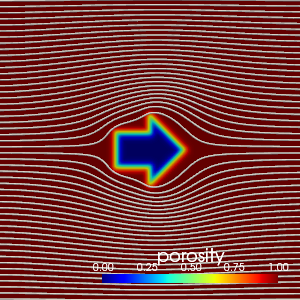

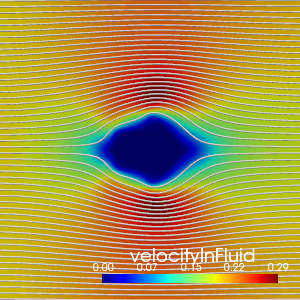

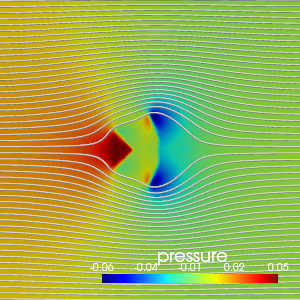

In [1]:
# @title Display VTK file { vertical-output: true }
import pyvista as pv
import math

# @markdown #Settings
# @markdown streamlines_point = length or width [m]

pv.set_jupyter_backend('static')
pv.global_theme.notebook = True
pv.start_xvfb()

def create_streamlines(mesh, scalar_field, start_point, end_point, n_points=51, max_time=100.0):
    streamlines = mesh.streamlines(
        'velocityInFluid',
        pointa=start_point,
        pointb=end_point,
        n_points=n_points,
        max_time=max_time,
        progress_bar=False,
    )
    return streamlines.tube(radius=streamlines_width), streamlines

def create_plotter(mesh, scalar_field, streamline_params):
    dargs = dict(
        scalars=scalar_field,
        cmap="jet",
        show_scalar_bar=False,
        opacity=1,
    )

    dargs_scalar = dict(
        color=font_color,
        interactive=True,
        vertical=False,
        title_font_size=18,
        label_font_size=10,
        outline=False,
        fmt='%5.2f',
    )

    pl = pv.Plotter(window_size=(300, 300))
    streamlines = None  # Initialize outside of the block

    if streamline_params["enabled"]:
        streamlines_tube, streamlines = create_streamlines(
            mesh,
            scalar_field,
            streamline_params["start_point"],
            streamline_params["end_point"],
            n_points=streamline_params["n_points"],
            max_time=streamline_params["max_time"],
        )
        pl.add_mesh(streamlines_tube, color=streamline_params["color"])

    pl.add_mesh(mesh, **dargs)
    pl.add_scalar_bar(scalar_field, **dargs_scalar)

    pl.camera_position = 'xy'
    pl.camera.roll += 180
    pl.camera.azimuth = 180
    pl.camera.zoom(zoom)

    return pl, streamlines

streamlines_point = 7.745967 #@param {type:"raw"}
streamlines_enabled = True  # @param {type:"boolean"}
streamlines_points = 51 #@param {type:"integer"}
streamlines_width = 0.02 #@param {type:"raw"}
streamlines_color = "white" # @param ["white", "red", "black", "yellow", "blue", "green"]
font_color = "white" # @param ["white", "red", "black", "yellow", "blue", "green"]
zoom = 1.5 #@param {type:"raw"}

mesh = pv.read('/content/output/output_paraview.vtk')

# List of parameters to visualize
parameters = ["porosity", "velocityInFluid", "pressure"]

# Streamline parameters
l = streamlines_point
streamline_params = {
    "enabled": streamlines_enabled,
    "start_point": (-l / 2, -l / 2, 0),
    "end_point": (-l / 2, l / 2, 0),
    "n_points": streamlines_points,
    "max_time": 100.0,
    "width": streamlines_width,
    "color": streamlines_color
}

for param in parameters:
    plotter, streamlines = create_plotter(mesh, param, streamline_params)
    plotter.show(screenshot=f'/content/output/{param}.png')


In [ ]:
# @title Zip output file for download
%mkdir -p download
%cp -r output download
%cp -r tmp download
!zip -r download download

## Reference

[1] Oshima.N, A Novel approach for wall-boundary immersed flow simulation: proposal of modified Navier-Stokes equation, Mechanical Engineering Journal. Vol.18, No.4 (2023)

[2] 大島, 流れの数値解析:固体境界が埋め込まれた改良ナビエ・ストークス方程式の解法, 北海道大学学術成果コレクション(HUBCAP), 資源タイプsoftware (2023), URL: https://eprints.lib.hokudai.ac.jp/dspace/handle/2115/89344